# **Proyecto Semestral - MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**


**Integrantes:**

- **Cristian Oyarzo M.**
- **Sebastián Quenti A.**


## **Configuración e Importación de Librerías**

En esta sección, se importarán las librerías necesarias para el desarrollo y análisis del proyecto.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
import optuna
from optuna.visualization import plot_param_importances
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from ydata_profiling import ProfileReport
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler

import mlflow
import mlflow.sklearn
from zipfile import ZipFile
import os
import joblib

import shap


C:\Users\sebit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## **Introducción**

El presente proyecto se centra en el desarrollo de un modelo predictivo capaz de estimar la **probabilidad de morosidad** de los clientes de un banco. El objetivo principal es identificar aquellos clientes que son más propensos a incumplir en sus pagos, permitiendo a la institución financiera tomar decisiones informadas para gestionar riesgos y maximizar ingresos.

Los datos utilizados corresponden a los archivos con los conjuntos ($X_{t0}$, $y_{t0}$), ($X_{t1}$, $y_{t1}$) y ($X_{t2}$, $y_{t2}$). Cabe destacar que inicialmente no se disponía de todos estos archivos y que, a medida que se profundiza en este informe, se utilizan más datos. También, inicialmente no existía un balance de clases en ($X_{t0}$, $y_{t0}$); sin embargo, en los demás archivos existía desbalance de clases, con clase predominante la negativa (no morosidad).

Los conjunto de datos incluye variables relacionadas con el perfil financiero y comportamental de los clientes. Estas variables abarcan tanto datos numéricos (por ejemplo, número de transacciones o el tiempo de existencia de una billetera) como categóricos (por ejemplo, *market_ht_trendmode*, que indica el modo de tendencia Hilbert del mercado).

Se seleccionó el **Área Bajo la Curva de Precisión-Recall (AUC-PR)** como métrica principal para evaluar los modelos. Esta métrica se centra en el rendimiento de la clase positiva (clientes morosos) y mide la capacidad del modelo para identificar correctamente a los clientes de alto riesgo mientras minimiza los falsos positivos. La AUC-PR es especialmente adecuada para problemas desbalanceados. Además, el cálculo del AUC-PR nos brinda una herramienta para evaluar de manera efectiva el rendimiento de nuestro modelo, tomando en cuenta los umbrales y el impacto de las decisiones en escenarios críticos. 

El AUC-PR, es una métrica que es particularmente útil cuando buscamos analizar el rendimiento del modelo al variar los umbrales de decisión (thresholds) en la predicción de probabilidades, lo que justifica aún más su elección. Además, se consideran métricas complementarias como la precision y el recall, que contribuyen a una interpretación más completa del rendimiento del modelo.

Previo al entrenamiento de los modelos, se realizaron transformaciones intermedias mediante **Pipelines** y **ColumnTransformers**. Estas incluyeron la imputación de valores faltantes, la eliminación de variables redundantes y el escalado de las variables numéricas, asegurando una adecuada preparación de los datos para el modelado. Este enfoque estructurado permite garantizar resultados consistentes y alineados con los objetivos del proyecto.

Para resolver el problema, inicialmente se utilizaron cuatro modelos supervisados:
1. **XGBoost**: Un modelo basado en boosting, altamente eficiente para problemas con datos tabulares.
2. **CatBoost**: Destacado por manejar datos categóricos de forma nativa y eficiente.
3. **LightGBM**: Una opción rápida y eficaz para conjuntos de datos grandes.
4. **Regresión Logística**: Utilizada como referencia base para establecer una línea base comparativa.

En etapas avanzadas del proyecto se decidió centrar los esfuerzos en XGBoost debido a su buen desempeño inicial y su fama por ser altamente eficiente y robusto en problemas de clasificación.

El proyecto arrojó resultados satisfactorios. En las tres etapas del proyecto se alcanzaron valores de AUC-PR de 0.7914172453, 0.853889004 y 0.7510044866, posicionándonos en los lugares 5°, 8° y 2° respectivamente (al momento de redactar esta introducción) de entre aproximadamente 20 equipos participantes. No obstante, estos resultados podrían haber sido mejores con más tiempo disponible, lo que indica que hay margen de mejora en la metodología empleada.

---
## **Preprocesamiento**

### **Análisis exploratorio de datos**

Se cargan los datos proporcionados para la primera etapa del proyecto.

In [2]:
df_x0 = pd.read_parquet('X_t0.parquet')
df_x1 = pd.read_parquet('X_t1.parquet')
df_y0 = pd.read_parquet('y_t0.parquet')

A continuación se listan la totalidad de variables en la base de datos:
1. **borrow_block_number**: Número de bloque en el que ocurrió el préstamo.
2. **borrow_timestamp**: Marca temporal que indica el momento del préstamo.
3. **wallet_address**: Dirección de la billetera asociada a las transacciones.
4. **first_tx_timestamp**: Fecha y hora de la primera transacción registrada de la billetera.
5. **last_tx_timestamp**: Fecha y hora de la última transacción registrada de la billetera.
6. **wallet_age**: Tiempo de existencia de la billetera en días.
7. **incoming_tx_count**: Cantidad total de transacciones entrantes a la billetera.
8. **outgoing_tx_count**: Cantidad total de transacciones salientes desde la billetera.
9. **net_incoming_tx_count**: Diferencia neta entre transacciones entrantes y salientes.
10. **total_gas_paid_eth**: Suma total de gas pagado en Ethereum (ETH) por la billetera.
11. **avg_gas_paid_per_tx_eth**: Promedio de gas pagado por transacción en ETH.
12. **risky_tx_count**: Cantidad de transacciones clasificadas como riesgosas.
13. **risky_unique_contract_count**: Número único de contratos asociados con transacciones riesgosas.
14. **risky_first_tx_timestamp**: Marca temporal de la primera transacción riesgosa registrada.
15. **risky_last_tx_timestamp**: Marca temporal de la última transacción riesgosa registrada.
16. **risky_first_last_tx_timestamp_diff**: Diferencia de tiempo entre la primera y la última transacción riesgosa.
17. **risky_sum_outgoing_amount_eth**: Suma total de ETH saliente en transacciones riesgosas.
18. **outgoing_tx_sum_eth**: Suma total de ETH saliente en todas las transacciones.
19. **incoming_tx_sum_eth**: Suma total de ETH entrante en todas las transacciones.
20. **outgoing_tx_avg_eth**: Promedio de ETH saliente por transacción.
21. **incoming_tx_avg_eth**: Promedio de ETH entrante por transacción.
22. **max_eth_ever**: Máximo balance en ETH registrado en la billetera.
23. **min_eth_ever**: Mínimo balance en ETH registrado en la billetera.
24. **total_balance_eth**: Balance total actual de la billetera en ETH.
25. **risk_factor**: Factor de riesgo calculado para la billetera.
26. **total_collateral_eth**: Colateral total en ETH asociado a la billetera.
27. **total_collateral_avg_eth**: Promedio de colateral total en ETH.
28. **total_available_borrows_eth**: Cantidad total de ETH disponible para préstamos.
29. **total_available_borrows_avg_eth**: Promedio de ETH disponible para préstamos.
30. **avg_weighted_risk_factor**: Promedio ponderado del factor de riesgo.
31. **risk_factor_above_threshold_daily_count**: Número de días en que el factor de riesgo estuvo por encima de un umbral.
32. **avg_risk_factor**: Promedio general del factor de riesgo.
33. **max_risk_factor**: Valor máximo del factor de riesgo registrado.
34. **borrow_amount_sum_eth**: Suma total de los montos prestados en ETH.
35. **borrow_amount_avg_eth**: Promedio de los montos prestados en ETH.
36. **borrow_count**: Número total de transacciones de préstamo.
37. **repay_amount_sum_eth**: Suma total de los montos reembolsados en ETH.
38. **repay_amount_avg_eth**: Promedio de los montos reembolsados en ETH.
39. **repay_count**: Número total de transacciones de reembolso.
40. **borrow_repay_diff_eth**: Diferencia entre el monto prestado y el reembolsado en ETH.
41. **deposit_count**: Número total de depósitos realizados.
42. **deposit_amount_sum_eth**: Suma total de los depósitos en ETH.
43. **time_since_first_deposit**: Tiempo transcurrido desde el primer depósito registrado.
44. **withdraw_amount_sum_eth**: Suma total de los retiros en ETH.
45. **withdraw_deposit_diff_if_positive_eth**: Diferencia positiva entre retiros y depósitos en ETH.
46. **liquidation_count**: Número total de liquidaciones registradas.
47. **time_since_last_liquidated**: Tiempo transcurrido desde la última liquidación.
48. **liquidation_amount_sum_eth**: Suma total en ETH liquidada.
49. **market_adx**: Índice direccional promedio del mercado.
50. **market_adxr**: Índice direccional promedio suavizado del mercado.
51. **market_apo**: Oscilador del precio promedio del mercado.
52. **market_aroonosc**: Oscilador de Aroon para el mercado.
53. **market_aroonup**: Valor de Aroon-Up del mercado.
54. **market_atr**: Rango verdadero promedio del mercado.
55. **market_cci**: Índice de canal de productos básicos del mercado.
56. **market_cmo**: Oscilador de momento de Chande del mercado.
57. **market_correl**: Correlación del mercado.
58. **market_dx**: Índice direccional del mercado.
59. **market_fastk**: Componente rápido K del estocástico del mercado.
60. **market_fastd**: Componente rápido D del estocástico del mercado.
61. **market_ht_trendmode**: Modo de tendencia Hilbert del mercado.
62. **market_linearreg_slope**: Pendiente de la regresión lineal del mercado.
63. **market_macd_macdext**: Componente MACD extendido del mercado.
64. **market_macd_macdfix**: Componente MACD fijo del mercado.
65. **market_macd**: Línea MACD del mercado.
66. **market_macdsignal_macdext**: Señal MACD extendida del mercado.
67. **market_macdsignal_macdfix**: Señal MACD fija del mercado.
68. **market_macdsignal**: Línea de señal MACD del mercado.
69. **market_max_drawdown_365d**: Máxima caída en 365 días del mercado.
70. **market_natr**: Rango verdadero promedio normalizado del mercado.
71. **market_plus_di**: Indicador direccional positivo del mercado.
72. **market_plus_dm**: Movimiento direccional positivo del mercado.
73. **market_ppo**: Oscilador de porcentaje de precio del mercado.
74. **market_rocp**: Cambio porcentual del precio del mercado.
75. **market_rocr**: Relación de cambio porcentual del mercado.
76. **unique_borrow_protocol_count**: Número único de protocolos de préstamo utilizados.
77. **unique_lending_protocol_count**: Número único de protocolos de préstamo activos.
78. **target**: Variable objetivo que indica el estado de morosidad del cliente.


Para el Análisis Exploratorio de Datos (EDA) se utilizó la herramienta de generación automática de perfiles con el siguiente código:

In [3]:
# profile = ProfileReport(
#     df_x0,
#     title="Análisis Exploratorio de Datos Automático",
#     explorative=True
# )

# # Guarda el informe como un archivo HTML
# profile.to_file("EDA_Reporte.html")

Debido a la altísima cantidad de variables en los datos, esta herramienta permite generar un informe detallado que incluye estadísticas descriptivas, detección de valores faltantes, correlaciones, distribuciones y otros aspectos clave de los datos, facilitando una comprensión global y eficiente de la información disponible. Este reporte será anexado a la entrega.

In [4]:
df_y0['target'].value_counts()

target
1    22656
0    21640
Name: count, dtype: int64

En el análisis general de la base de datos se identificaron 73 variables numéricas y 3 variables categóricas, todas ellas sin valores nulos. Además, se identificó que la variable '*wallet_address*' corresponde a tipo id.

Algunas de las variables siguen una distribución similar a normal como '*market_macd_macdext*', '*market_apo*' o '*market_linearreg_slope*'. Estas variables están asociadas principalmente al mercado.

Otras variables como liquidation_amount_sum_eth o withdraw_deposit_diff_if_positive_eth tienen un porcentaje alto de ceros, pese a ser númericas reales. Estas variables están asociadas generalmente a los ETH.

Realizando un `value_counts` a la columna target de **y_t0** se obtuvo que las clases se encuentran balanceadas, ya que son 22656 valores en 1 y 21640 valores en 0.

Adicionalmente, se realizará un EDA manual para complementar información del EDA automático.

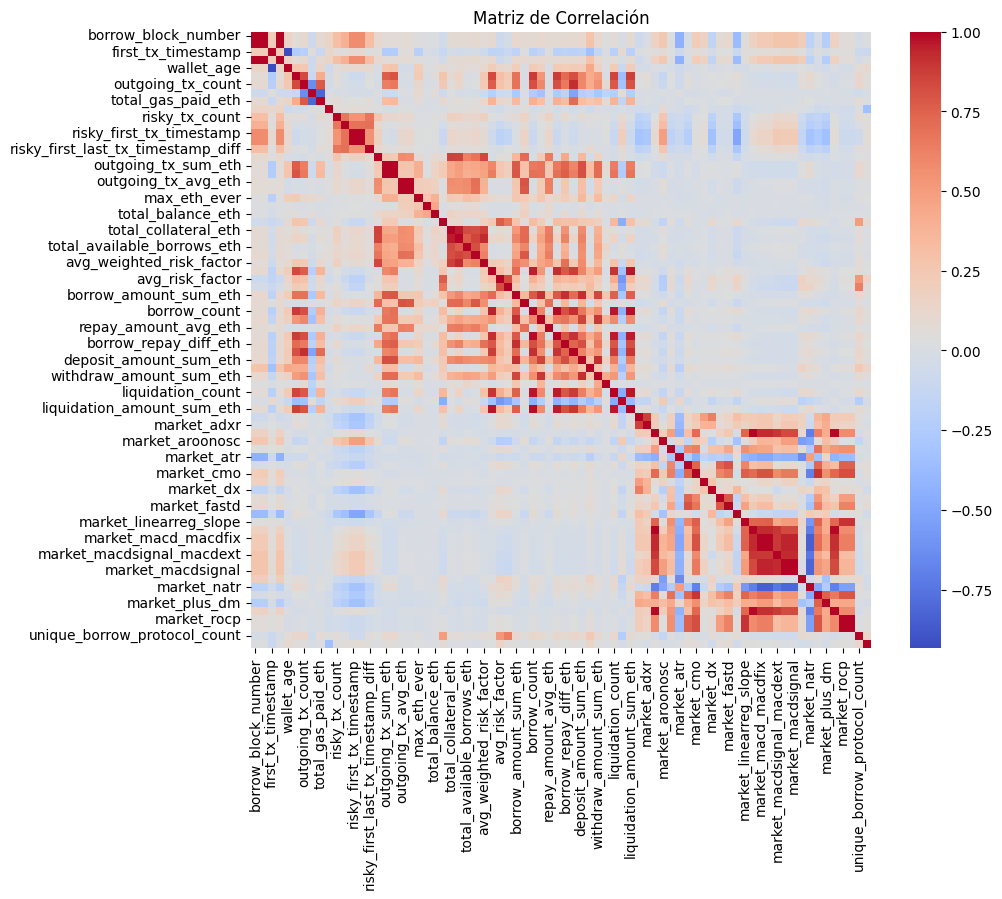

In [5]:
num_columns = df_x0.select_dtypes(include=['float64', 'int64']).columns

# Correlación entre variables numéricas
plt.figure(figsize=(10, 8))
correlation_matrix = df_x0[num_columns].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

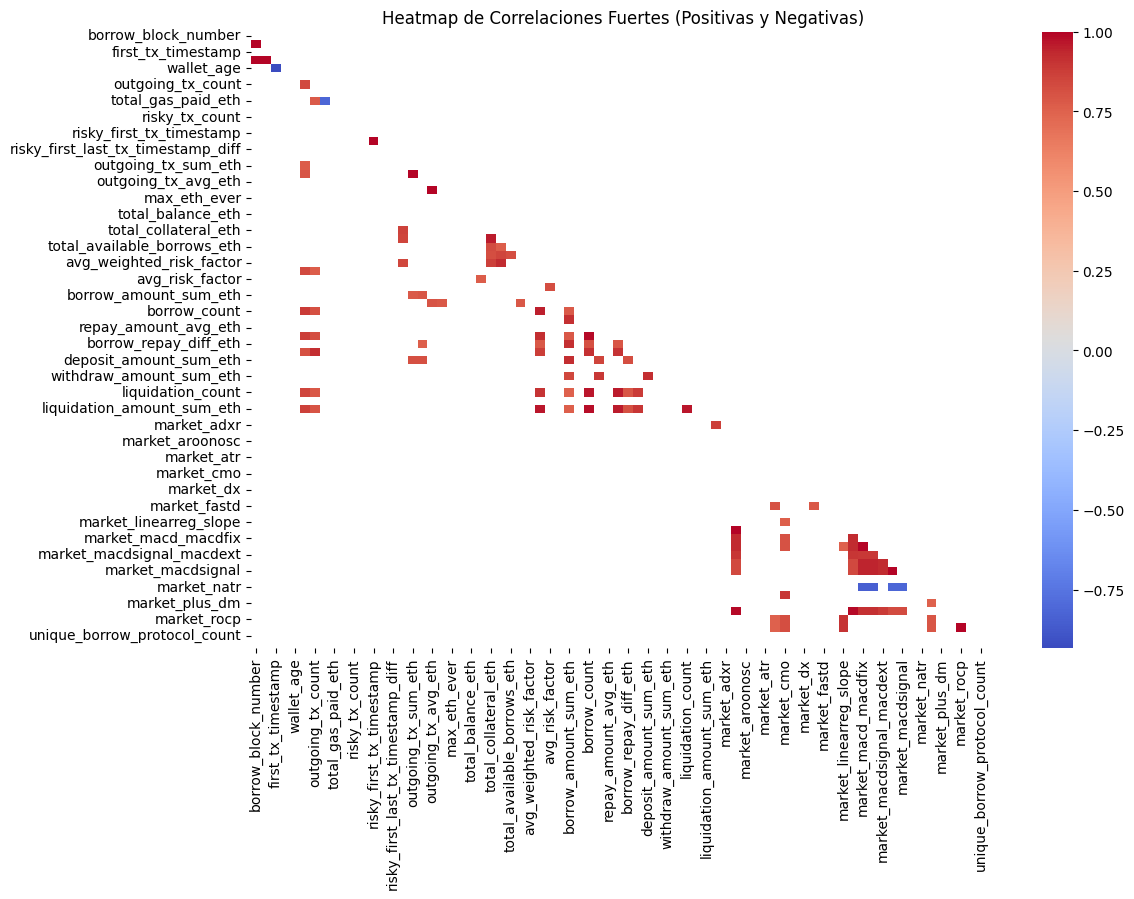

Pares de variables con correlación alta (por encima del umbral):
                       level_0                  level_1  correlation
4685       market_macd_macdext               market_apo     1.000000
3785                market_apo      market_macd_macdext     1.000000
5620               market_rocr              market_rocp     1.000000
5545               market_rocp              market_rocr     1.000000
925   risky_first_tx_timestamp  risky_last_tx_timestamp     1.000000
...                        ...                      ...          ...
4856               market_macd              market_natr    -0.848011
5230               market_natr      market_macd_macdfix    -0.848121
4780       market_macd_macdfix              market_natr    -0.848121
306                 wallet_age       first_tx_timestamp    -0.932773
156         first_tx_timestamp               wallet_age    -0.932773

[254 rows x 3 columns]


In [7]:
# Matriz de correlación
correlation_matrix = df_x0[num_columns].corr()

# Filtrar solo las correlaciones fuertes (por encima de un umbral 0.75)
threshold = 0.75
strong_correlation = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

# Mapa de calor solo con las correlaciones fuertes
plt.figure(figsize=(12, 8))
sns.heatmap(
    strong_correlation, 
    annot=False, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool))
)
plt.title("Heatmap de Correlaciones Fuertes (Positivas y Negativas)")
plt.show()

# Pares de variables con alta correlación
correlated_pairs = (
    correlation_matrix.stack()
    .reset_index()
    .rename(columns={0: "correlation"})
    .query("abs(correlation) >= @threshold and level_0 != level_1")
    .sort_values(by="correlation", ascending=False)
)

print("Pares de variables con correlación alta (por encima del umbral):")
print(correlated_pairs)

Las correlaciones encontradas en los datos ofrecen información importante sobre cómo las variables están relacionadas entre sí, lo que puede ser crítico para reducir redundancias y entender la estructura interna de los datos.

Las correlaciones perfectas o cercanas a 1 entre variables como *market_macd_macdext* y *market_apo*, así como *market_rocr* y *market_rocp*, indican una relación lineal directa. Esto implica que estas variables contienen información prácticamente redundante.

Por otro lado, las correlaciones negativas significativas, como la observada entre *wallet_age* y *first_tx_timestamp*, reflejan una relación inversa. En este caso, el tiempo desde el primer uso de una billetera y la antigüedad de la misma están intrínsecamente relacionadas, lo cual es lógico dada la naturaleza temporal de los datos. Este tipo de relación puede ser útil para segmentar usuarios o predecir comportamientos futuros basados en patrones históricos.

El análisis también revela un agrupamiento claro entre indicadores técnicos del mercado, como *market_macd_macdfix*, *market_rocp* y *market_natr*. Estas variables muestran una interdependencia fuerte, lo que sugiere que están basadas en cálculos similares o reflejan aspectos relacionados del comportamiento del mercado. Este agrupamiento podría ser simplificado mediante técnicas como el Análisis de Componentes Principales (PCA), reduciendo la dimensionalidad del conjunto de datos sin perder información clave.

Varianza explicada por cada componente:
[0.18424808 0.16567271 0.10880811 0.07816071 0.04351423 0.03982114
 0.03414139 0.02785805 0.02762966 0.02432178]

Varianza explicada acumulada:
[0.18424808 0.34992079 0.4587289  0.53688961 0.58040384 0.62022498
 0.65436637 0.68222442 0.70985408 0.73417586]


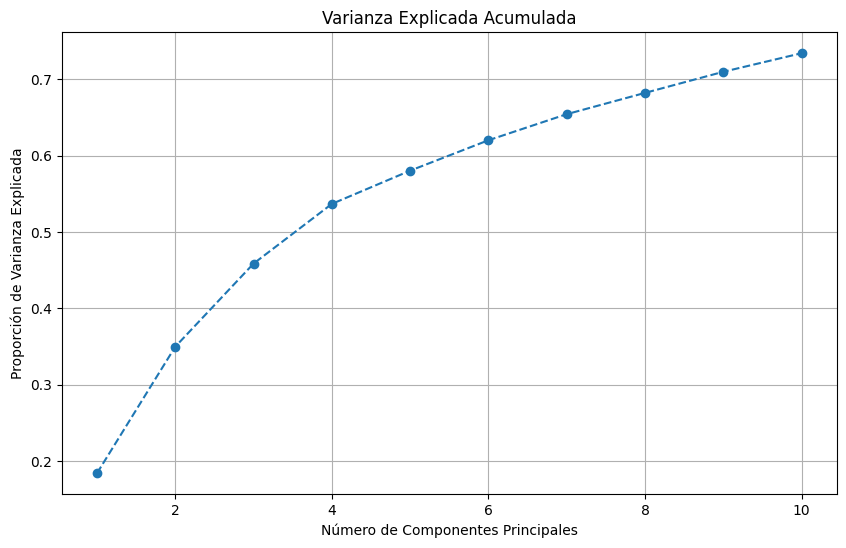

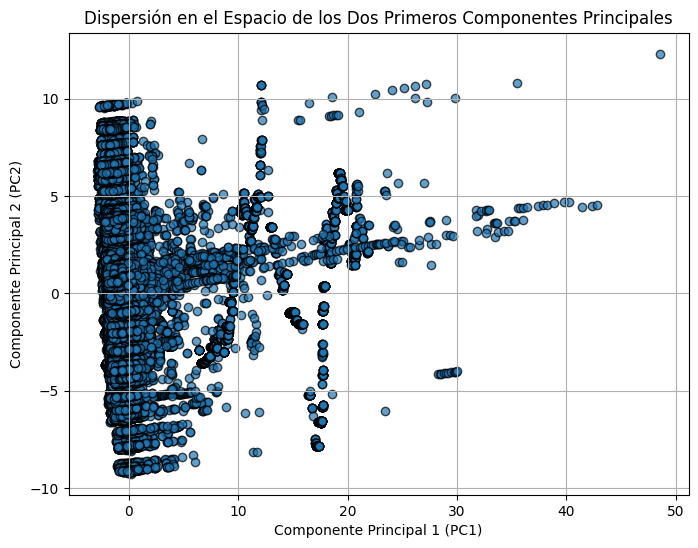

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

num_columns = df_x0.select_dtypes(include=['float64', 'int64'])

# Estandarizar los datos para minimizar los efectos de los outliers
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_columns)

# Aplicar PCA
pca = PCA(n_components=10)  
principal_components = pca.fit_transform(scaled_data)

# Crear un DataFrame con los resultados del PCA
pca_columns = [f"PC{i+1}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(principal_components, columns=pca_columns)

# Varianza explicada por cada componente
print("Varianza explicada por cada componente:")
print(pca.explained_variance_ratio_)

print("\nVarianza explicada acumulada:")
print(np.cumsum(pca.explained_variance_ratio_))

# Varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    np.cumsum(pca.explained_variance_ratio_),
    marker='o', linestyle='--'
)
plt.title('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada')
plt.grid()
plt.show()

# Dispersión de los primeros dos componentes principales
plt.figure(figsize=(8, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.7, edgecolor='k')
plt.title('Dispersión en el Espacio de los Dos Primeros Componentes Principales')
plt.xlabel('Componente Principal 1 (PC1)')
plt.ylabel('Componente Principal 2 (PC2)')
plt.grid()
plt.show()

El gráfico de varianza explicada acumulada muestra que las primeras tres componentes principales explican aproximadamente el **45.9%** de la varianza total de los datos. Esto significa que casi la mitad de la información presente en las 73 variables originales puede ser resumida utilizando solo tres dimensiones (PC1, PC2 y PC3). Aunque el 73.4% de la varianza es explicada por las primeras diez componentes principales, la mayoría de la variabilidad está concentrada en las primeras pocas componentes, lo que sugiere que estas son las más relevantes para el análisis.

El gráfico de dispersión en el espacio definido por PC1 y PC2 muestra cómo los datos se distribuyen en las dos principales direcciones de máxima variabilidad. La dispersión indica una cierta agrupación, aunque no es claramente visible un patrón específico, como clusters compactos. Esto puede significar que las relaciones entre las variables están distribuidas de manera continua o que se necesitan componentes adicionales (PC3, PC4, etc.) para visualizar patrones más definidos.

Ahora se evaluarán los aportes de las variables a cada componente principal.

In [9]:
# Umbral mínimo de aporte
threshold = 0.2 

# Obtener los loadings
loadings = pd.DataFrame(
    pca.components_.T,  # Transponer para que las columnas sean los componentes principales
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],  # Nombres de los componentes principales
    index=num_columns.columns  # Nombres de las variables originales
)

# Variables que superen el umbral para cada componente
for i in range(pca.n_components_):
    significant_loadings = loadings.iloc[:, i][loadings.iloc[:, i].abs() >= threshold]
    print(f"\nVariables con aporte significativo en PC{i+1} (umbral: {threshold}):")
    print(significant_loadings)



Variables con aporte significativo en PC1 (umbral: 0.2):
incoming_tx_count                          0.213757
outgoing_tx_count                          0.209527
outgoing_tx_sum_eth                        0.226957
incoming_tx_sum_eth                        0.231692
risk_factor_above_threshold_daily_count    0.208723
borrow_amount_sum_eth                      0.251450
borrow_count                               0.225281
repay_amount_sum_eth                       0.215084
repay_count                                0.225269
borrow_repay_diff_eth                      0.245269
deposit_count                              0.216848
deposit_amount_sum_eth                     0.239235
withdraw_amount_sum_eth                    0.206657
liquidation_count                          0.219753
liquidation_amount_sum_eth                 0.219453
Name: PC1, dtype: float64

Variables con aporte significativo en PC2 (umbral: 0.2):
market_apo                   0.252621
market_cmo                   0.257557
ma

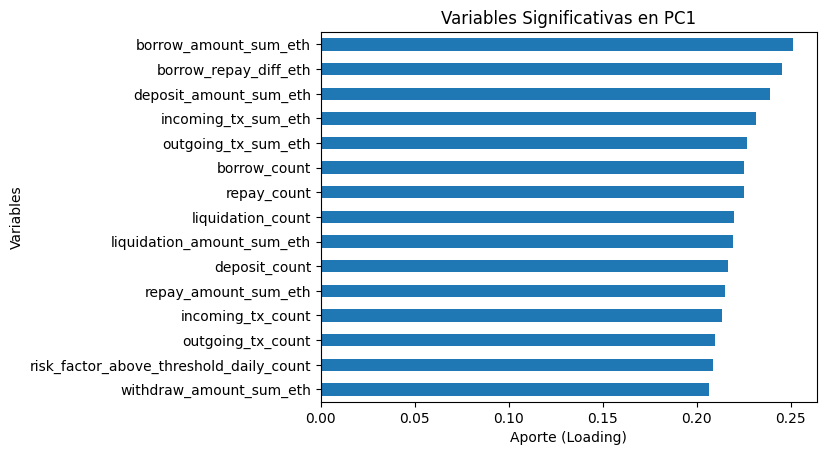

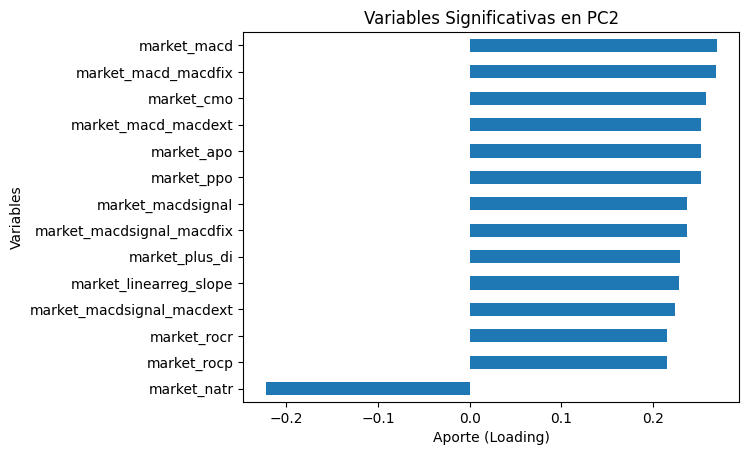

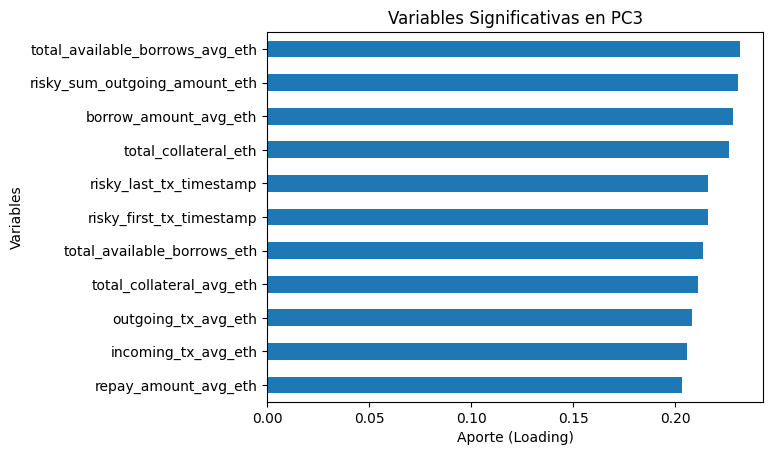

In [10]:
# Aporte de las variables a las 3 primeras principales componentes
for i in range(3):
    significant_loadings = loadings.iloc[:, i][loadings.iloc[:, i].abs() >= threshold]
    if not significant_loadings.empty:
        significant_loadings.sort_values().plot(kind='barh', title=f"Variables Significativas en PC{i+1}")
        plt.xlabel("Aporte (Loading)")
        plt.ylabel("Variables")
        plt.show()

La PC1 está fuertemente influenciada por variables relacionadas con transacciones y préstamos, captura una dimensión general de actividad transaccional, representando la escala de interacción financiera. Esta componente es relevante para clasificar individuos o entidades con base en su nivel de actividad económica en el sistema.

La PC2 está dominada por indicadores de mercado técnicos, la cual captura la variabilidad asociada al análisis técnico de los mercados. Esta componente parece resumir tendencias y patrones técnicos utilizados en la evaluación del comportamiento del mercado, lo cual puede ser clave para modelar decisiones de inversión o riesgos asociados al mercado.

La PC3 está influenciada por variables que reflejan balances y colaterales, lo que mide el perfil financiero más relacionado con la disponibilidad de recursos y el nivel de apalancamiento o garantía disponible. Es útil para evaluar la solvencia y el comportamiento de riesgo de los usuarios.

In [ ]:
# Análisis avanzado de outliers usando IQR
for col in num_columns:
    Q1 = df_x0[col].quantile(0.25)
    Q3 = df_x0[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df_x0[col] < (Q1 - 1.5 * IQR)) | (df_x0[col] > (Q3 + 1.5 * IQR)))
    print(f"\nNúmero de valores atípicos en {col}: {outliers.sum()}")
    if outliers.sum() > 0:
        plt.figure()
        sns.boxplot(x=df_x0[col])
        plt.title(f"Valores atípicos en {col}")
        plt.xlabel(col)
        plt.show()

# Se realiza un "Clear outputs" dado que entrega demasiados gráficos 
# y no se quiere saturar el informe

Se identificó un número considerable de valores atípicos en múltiples variables del conjunto de datos. Este análisis se realizó utilizando el rango intercuartílico (IQR) como criterio, donde cualquier valor por debajo de \( Q1 - 1.5 * IQR \) o por encima de \( Q3 + 1.5 * IQR \) fue clasificado como un valor atípico.

Aunque estos valores atípicos representan posibles anomalías o casos excepcionales que podrían influir en el análisis o los modelos subsecuentes, debido a restricciones de tiempo, no se implementaron estrategias específicas para su tratamiento. Esto constituye una de las limitaciones de este proyecto, ya que no se realizaron tareas como:
- Imputación de valores atípicos.
- Transformaciones para reducir su impacto.
- Eliminación o etiquetado de dichos datos.

Se fija una semilla aleatoria para garantizar la reproducibilidad de los resultados a lo largo del desarrollo del proyecto:

In [5]:
rd = 1323

### **Preprocesamiento de Datos**

En esta etapa, se prepara el pipeline para preprocesar los datos de aquí en adelante


In [6]:
# Transformador personalizado para eliminar columnas específicas
class DropColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X.drop(columns=self.columns_to_drop, errors='ignore')

# Columnas categóricas y numéricas
categorical_features = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
numerical_features = [col for col in df_x0.columns if col not in categorical_features + ['wallet_address']]

# Pipeline para las variables numéricas
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores nulos con la media
    ('scaler', MinMaxScaler())                   # Min-Max Scaler
])

# Aplicar ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),  # Aplicar transformación a numéricas
        ('cat', 'passthrough', categorical_features)      # No hacer nada a las categóricas
    ]
)
preprocessor.set_output(transform="pandas")

# Pipeline general para el preprocesamiento completo
full_pipeline = Pipeline(steps=[
    ('drop_column', DropColumnTransformer(columns_to_drop=['wallet_address'])),  # Eliminar 'wallet_address'
    ('preprocessor', preprocessor)
])

#### Justificación del Pipeline

La implementación de estos pipelines está diseñada para preparar los datos de forma eficiente y estructurada. A continuación, se detallan y justifican las decisiones tomadas en cada etapa del pipeline:

1. **Eliminación de la columna _'*wallet_address*'_**:  
   Esta columna contiene identificadores únicos que no aportan valor predictivo al problema, ya que no están relacionadas con las características del cliente o su probabilidad de morosidad. Además, conservarla podría introducir ruido o sesgo en el modelo, especialmente en algoritmos que analizan patrones numéricos. No se decidió eliminar más columnas o una posible reducción de dimsionalidad, para entregar la mayor cantidad de información a los modelos, además los modelos serán en su mayoría basados en árboles, que manejan generalmente bien la alta dimensionalidad.

2. **Imputación de valores nulos en variables numéricas**: 
   Si bien inicialmente no se identificaron valores nulos, para evitar que la presencia de nulos en un futuro afecte negativamente el rendimiento de los modelos, se utiliza un imputador que reemplaza los valores faltantes con la media de cada columna. Este método es adecuado porque mantiene la distribución central de las variables sin introducir sesgos significativos, especialmente en conjuntos de datos relativamente grandes.

3. **Normalización de variables numéricas con `MinMaxScaler`**:  
   La normalización ajusta los valores al rango [0, 1], lo que asegura que todas las características numéricas tengan la misma escala. Esto es particularmente importante en modelos basados en distancias (como SVM) y algoritmos que son sensibles a la magnitud de las variables (como regresiones logísticas o redes neuronales).

4. **No transformación de variables categóricas**:  
   Las tres variables categóricas seleccionadas (_'market_ht_trendmode'_, _'unique_borrow_protocol_count'_, _'unique_lending_protocol_count'_) son binarias. Por lo tanto, no se aplica `OneHotEncoder` ni técnicas similares, ya que sería redundante e innecesario.


#### División inicial de los datos

A continuacións se divide el conjunto de datos en dos partes para garantizar una evaluación adecuada del modelo:

- **70%** para entrenamiento: Utilizado para ajustar los modelos.
- **30%** para prueba: Reservado para evaluar el rendimiento de los modelos.


In [7]:
# División en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(df_x0, df_y0, test_size=0.3, random_state=rd, stratify=df_y0)

# Asegurarse de que los vectores objetivo sean de una dimensión y las variables númericas sean tipo float (compatiblidad con librerias usadas más adelante)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test) 
X_train = X_train.astype({col: 'float64' for col in X_train.select_dtypes(include=['int']).columns})
X_test = X_test.astype({col: 'float64' for col in X_test.select_dtypes(include=['int']).columns})

---
## **Modelamiento**

Se comienza la construcción y evaluación de modelos predictivos con el objetivo de estimar la probabilidad de morosidad de los clientes (datos etapa 1).


Métrica utilizada (AUC-PR, tal y como se menciona en la introducción):

In [8]:
# Definir una métrica personalizada para AUC-PR
def custom_auc_pr(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return auc(recall, precision)

# Crear un scorer basado en la métrica personalizada
auc_pr_scorer = make_scorer(custom_auc_pr, response_method = 'predict_proba')

In [9]:
# Configurar el experimento en MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Etapa 1 Proyecto")

<Experiment: artifact_location='mlflow-artifacts:/577771263515207601', creation_time=1733977003079, experiment_id='577771263515207601', last_update_time=1733977003079, lifecycle_stage='active', name='Etapa 1 Proyecto', tags={}>

Para este experimento, se emplea la técnica de GridSearch con validación cruzada para determinar la combinación óptima de hiperparámetros para cada modelo. GridSearch permite explorar de manera sistemática un rango predefinido de configuraciones, evaluando el rendimiento del modelo en cada una de ellas. La métrica seleccionada para esta optimización es el AUC-PR, ideal para problemas desbalanceados, ya que se enfoca en la capacidad del modelo para identificar correctamente la clase positiva, tal y como se mencionó en la introducción.

La validación cruzada utilizada es de tipo estratificada, con k=5 pliegues. Esto significa que el conjunto de entrenamiento se divide en 5 subconjuntos (pliegues), y en cada iteración, uno de estos subconjuntos se reserva para validación, mientras que los otros 4 se usan para entrenamiento. Este enfoque garantiza que cada observación se utilice tanto para entrenamiento como para validación, proporcionando una evaluación robusta del modelo y minimizando el riesgo de sobreajuste. La estratificación asegura además que la proporción de clases se mantenga consistente en cada pliegue, un factor crucial en datasets desbalanceados.



#### **Modelo Base: Regresión Logística**

Se selecciona la Regresión Logística como modelo base debido a su simplicidad, rapidez y efectividad en problemas de clasificación binaria. Su rendimiento razonable y su bajo costo computacional lo convierten en una herramienta ideal para establecer un punto de referencia antes de implementar otros modelos.

La **Regresión Logística** es un modelo estadístico utilizado para problemas de clasificación binaria, donde el objetivo es predecir la probabilidad de pertenencia a una de dos clases. Este modelo asume una relación lineal entre las variables independientes (predictoras) y el logaritmo de las probabilidades (odds ratio) de la clase positiva. La salida de la regresión logística es una probabilidad en el rango [0, 1], que puede transformarse en una predicción de clase mediante un umbral (por defecto, 0.5). 

En este experimento, se ajustaron dos hiperparámetros clave de la Regresión Logística:

1. **`C` (Inverso de la Regularización)**:  
   - Controla la fuerza de la regularización L2 aplicada al modelo.
   - Valores pequeños (`C < 1`) aplican una mayor penalización, reduciendo la complejidad del modelo y previniendo el sobreajuste.
   - Valores altos (`C > 1`) disminuyen la regularización, permitiendo un ajuste más preciso a los datos de entrenamiento.

2. **`penalty` (Tipo de Regularización)**:  
   - Se evaluaron dos tipos de regularización:
     - **`l1` (Lasso)**: Promueve la selección de características al forzar coeficientes de predictores irrelevantes a ser exactamente cero.
     - **`l2` (Ridge)**: Reduce el tamaño de los coeficientes para todas las características, ayudando a manejar multicolinealidad y prevenir el sobreajuste.

Estos hiperparámetros se seleccionaron porque influyen directamente en la capacidad del modelo para generalizar y manejar datos con alta dimensionalidad o correlación entre características. Se utilizó una grilla limitada al tratarse de un modelo base.

In [10]:
# Definir modelo base
pipeline_bl = Pipeline([
    ('preprocessing', full_pipeline),
    ('log_reg', LogisticRegression(random_state=rd, solver='liblinear'))
])

# Definir grilla de hiperparámetros (Se utiliza una grilla limitada al tratarse de un baseline)
param_grid = {
    'log_reg__C': [1, 10],  
    'log_reg__penalty': ['l1', 'l2']  
}

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)

# Definir el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_bl,
    param_grid=param_grid,
    scoring=auc_pr_scorer, 
    cv=cv,
    verbose=10,
    n_jobs=-1
)

# Run en MLflow para este modelo
input_example = X_test.head(1) 
with mlflow.start_run(run_name="Regresión logística - Primera Iteración"):
    grid_search.fit(X_train, y_train)

    # Registrar los mejores parámetros
    best_params = grid_search.best_params_
    print(f"Mejores parámetros: {best_params}")
    mlflow.log_params(best_params)

    # Evaluar el modelo con el conjunto de test
    best_model_lr = grid_search.best_estimator_
    y_test_pred = best_model_lr.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
    test_auc_pr = custom_auc_pr(y_test, y_test_pred)  # Calcular AUC-PR
    print(f"AUC-PR en el conjunto de test: {test_auc_pr}")

    # Calcular métricas comunes
    y_test_pred_class = (y_test_pred >= 0.5).astype(int)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    # Registrar métricas en MLflow
    mlflow.log_metric("AUC-PR", test_auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

    # Registrar el modelo entrenado
    mlflow.sklearn.log_model(
        sk_model=best_model_lr, 
        artifact_path="LogisticRegressionModel", 
        input_example=input_example
    )

    print("Modelo y métricas registrados en MLflow.")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores parámetros: {'log_reg__C': 10, 'log_reg__penalty': 'l1'}
AUC-PR en el conjunto de test: 0.863254809398311


c:\Users\crist\anaconda3\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Modelo y métricas registrados en MLflow.
🏃 View run Regresión logística - Primera Iteración at: http://127.0.0.1:5000/#/experiments/577771263515207601/runs/0a96c24ab3c04733886aa1b2f3dd0bbc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/577771263515207601


A continuación se presenta el *classification_report* del modelo:

In [11]:
print(classification_report(y_test, y_test_pred_class, target_names=['Clase No Morosa', 'Clase Morosa']))

                 precision    recall  f1-score   support

Clase No Morosa       0.73      0.78      0.76      6492
   Clase Morosa       0.78      0.72      0.75      6797

       accuracy                           0.75     13289
      macro avg       0.75      0.75      0.75     13289
   weighted avg       0.75      0.75      0.75     13289



Se obtuvo un AUC-PR de 0.86 en el conjunto de prueba, lo cual representa un punto de partida sólido para este proyecto. Se considera como objetivo identificar y desarrollar modelos que logren superar este desempeño. Equivalentemente, el resto de métricas como precision o recall tienen un margen de mejora considerable.

#### **Modelo 2: CatBoost**

Se selecciona el modelo de clasificación `CatBoostClassifier` debido a su capacidad para manejar de forma nativa variables categóricas y su eficacia en problemas complejos con grandes volúmenes de datos.

**CatBoostClassifier** es un modelo de aprendizaje automático basado en **gradient boosting** que destaca por su capacidad para manejar de forma nativa variables categóricas, su rapidez y su alto rendimiento en tareas de clasificación y regresión. CatBoost utiliza técnicas avanzadas como el **ordenamiento por permutación** para evitar el overfitting durante el entrenamiento, lo que lo convierte en una opción robusta para problemas complejos y con grandes volúmenes de datos. Además, su facilidad de uso y la reducción de la necesidad de preprocesamiento lo hacen ideal para manejar datasets con combinaciones de datos numéricos y categóricos.

En este experimento, se ajustaron los siguientes hiperparámetros clave de CatBoost:

1. **`iterations`** (Número de Iteraciones):  
   - Especifica el número total de árboles que se construirán durante el entrenamiento.  
   - Valores más altos pueden mejorar el rendimiento del modelo, pero incrementan el tiempo de entrenamiento y el riesgo de sobreajuste.

2. **`depth`** (Profundidad de los Árboles):  
   - Controla la complejidad de los árboles individuales.  
   - Valores pequeños (`depth=3`) favorecen un modelo más simple, mientras que valores mayores (`depth=5`) permiten capturar relaciones más complejas.

3. **`learning_rate`** (Tasa de Aprendizaje):  
   - Ajusta la contribución de cada árbol al modelo final.  
   - Tasa baja (`0.01`) ofrece un ajuste más lento y estable, mientras que tasas más altas (`0.1`) aceleran el aprendizaje a costa de un mayor riesgo de sobreajuste.

4. **`l2_leaf_reg`** (Regularización L2):  
   - Penaliza la magnitud de los pesos en los nodos hoja de los árboles para prevenir el sobreajuste.  
   - Valores bajos (`1`) ofrecen menos regularización, mientras que valores altos (`5`) aumentan la restricción.

Estos hiperparámetros fueron seleccionados por su impacto directo en la capacidad de CatBoost para generalizar. La grilla utilizada para la búsqueda sistemática permite encontrar un equilibrio entre la complejidad del modelo y su rendimiento en el conjunto de prueba.


In [12]:
# Definir el modelo CatBoost y su pipeline
pipeline_catboost = Pipeline([
    ('preprocessing', full_pipeline), 
    ('catboost', CatBoostClassifier(verbose=0, random_seed=rd))
])

# Definir grilla de hiperparámetros
param_grid = {
    'catboost__iterations': [100, 200],
    'catboost__depth': [3, 5],
    'catboost__learning_rate': [0.01, 0.1],
    'catboost__l2_leaf_reg': [1, 3, 5]
}

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)

# Definir el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_catboost,
    param_grid=param_grid,
    scoring=auc_pr_scorer, 
    cv=cv,
    verbose=10,
    n_jobs=-1
)

# Run en MLflow para este modelo
input_example = X_test.head(1)  # Ejemplo de entrada
with mlflow.start_run(run_name="CatBoost - Primera Iteración"):
    grid_search.fit(X_train, y_train)

    # Registrar los mejores parámetros
    best_params = grid_search.best_params_
    print(f"Mejores parámetros: {best_params}")
    mlflow.log_params(best_params)

    # Evaluar el modelo con el conjunto de test
    best_model_cb = grid_search.best_estimator_
    y_test_pred = best_model_cb.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
    test_auc_pr = custom_auc_pr(y_test, y_test_pred)  # Calcular AUC-PR
    print(f"AUC-PR en el conjunto de test: {test_auc_pr}")

    # Calcular métricas comunes
    y_test_pred_class = (y_test_pred >= 0.5).astype(int)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    # Registrar métricas en MLflow
    mlflow.log_metric("AUC-PR", test_auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

    # Registrar el modelo entrenado
    mlflow.sklearn.log_model(
        sk_model=best_model_cb, 
        artifact_path="CatBoostModel", 
        input_example=input_example
    )

    print("Modelo y métricas registrados en MLflow.")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'catboost__depth': 5, 'catboost__iterations': 200, 'catboost__l2_leaf_reg': 1, 'catboost__learning_rate': 0.1}
AUC-PR en el conjunto de test: 0.9299839004038601


c:\Users\crist\anaconda3\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Modelo y métricas registrados en MLflow.
🏃 View run CatBoost - Primera Iteración at: http://127.0.0.1:5000/#/experiments/577771263515207601/runs/d13a85061de94431b15f6cb08b452000
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/577771263515207601


A continuación se presenta el *classification_report* del modelo:

In [13]:
print(classification_report(y_test, y_test_pred_class, target_names=['Clase No Morosa', 'Clase Morosa']))

                 precision    recall  f1-score   support

Clase No Morosa       0.79      0.89      0.84      6492
   Clase Morosa       0.88      0.78      0.83      6797

       accuracy                           0.83     13289
      macro avg       0.84      0.84      0.83     13289
   weighted avg       0.84      0.83      0.83     13289



Se puede observar un aumento en la métrica clave AUC-PR respecto al modelo base (0.93 frente a los 0.86 de regresión logística).

#### **Modelo 3: LightGBM**

Se utiliza el modelo de clasificación `LGBMClassifier`.


El **LGBMClassifier** es un modelo de aprendizaje automático basado en **gradient boosting** que utiliza técnicas de optimización avanzadas, como el uso de histogramas y la construcción de hojas por profundidad, para acelerar el entrenamiento y reducir el uso de memoria. LightGBM es conocido por su capacidad para manejar grandes volúmenes de datos y su eficacia en tareas de clasificación y regresión, especialmente cuando el dataset contiene características numéricas de alta dimensionalidad. Además, su flexibilidad permite ajustar múltiples hiperparámetros para optimizar el rendimiento.

En este experimento, se ajustaron los siguientes hiperparámetros clave de LightGBM:

1. **`n_estimators`** (Número de Árboles):  
   - Define la cantidad de árboles construidos durante el entrenamiento.  
   - Valores más altos generalmente aumentan el rendimiento, aunque también incrementan el tiempo de entrenamiento.

2. **`max_depth`** (Profundidad Máxima de los Árboles):  
   - Limita la profundidad de los árboles individuales.  
   - Profundidades más bajas (`3`) reducen el riesgo de sobreajuste, mientras que profundidades mayores (`5`) capturan relaciones más complejas en los datos.

3. **`learning_rate`** (Tasa de Aprendizaje):  
   - Controla cuánto contribuye cada árbol al modelo final.  
   - Una tasa baja (`0.01`) ofrece un ajuste más estable, mientras que una tasa alta (`0.1`) permite un ajuste más rápido a costa de un mayor riesgo de sobreajuste.

4. **`reg_alpha`** (Regularización L1):  
   - Penaliza los coeficientes de las características menos importantes, promoviendo la selección de variables.  
   - Valores mayores incrementan la fuerza de esta penalización, ayudando a simplificar el modelo.

5. **`reg_lambda`** (Regularización L2):  
   - Reduce la magnitud de los coeficientes de las características para evitar sobreajuste.  
   - Valores altos (`10, 100`) ofrecen una mayor regularización, estabilizando el modelo.

Estos hiperparámetros fueron seleccionados por su impacto en la capacidad del modelo para equilibrar el ajuste y la generalización. La búsqueda de la combinación óptima se realizó utilizando una grilla sistemática y validación cruzada.


In [14]:
# Definir el modelo LightGBM y su pipeline
pipeline_lgbm = Pipeline([
    ('preprocessing', full_pipeline), 
    ('lightgbm', LGBMClassifier(random_state=rd))  
])

# Definir grilla de hiperparámetros
param_grid = {
    'lightgbm__n_estimators': [100, 200],
    'lightgbm__max_depth': [3, 5],
    'lightgbm__learning_rate': [0.01, 0.1],
    'lightgbm__reg_alpha': [0, 0.1]
}

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)

# Definir el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid,
    scoring=auc_pr_scorer, 
    cv=cv,
    verbose=10,
    n_jobs=-1
)

# Run en MLflow para este modelo
input_example = X_test.head(1)  # Ejemplo de entrada
with mlflow.start_run(run_name="LightGBM - Primera Iteración"):
    grid_search.fit(X_train, y_train)

    # Registrar los mejores parámetros
    best_params = grid_search.best_params_
    print(f"Mejores parámetros: {best_params}")
    mlflow.log_params(best_params)

    # Evaluar el modelo con el conjunto de test
    best_model_lgbm = grid_search.best_estimator_
    y_test_pred = best_model_lgbm.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
    test_auc_pr = custom_auc_pr(y_test, y_test_pred)  # Calcular AUC-PR
    print(f"AUC-PR en el conjunto de test: {test_auc_pr}")

    # Calcular métricas comunes
    y_test_pred_class = (y_test_pred >= 0.5).astype(int)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    # Registrar métricas en MLflow
    mlflow.log_metric("AUC-PR", test_auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

    # Registrar el modelo entrenado
    mlflow.sklearn.log_model(
        sk_model=best_model_lgbm, 
        artifact_path="LightGBMModel", 
        input_example=input_example
    )

    print("Modelo y métricas registrados en MLflow.")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Number of positive: 15859, number of negative: 15148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17103
[LightGBM] [Info] Number of data points in the train set: 31007, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511465 -> initscore=0.045869
[LightGBM] [Info] Start training from score 0.045869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

c:\Users\crist\anaconda3\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Modelo y métricas registrados en MLflow.
🏃 View run LightGBM - Primera Iteración at: http://127.0.0.1:5000/#/experiments/577771263515207601/runs/03c0c7fb5e984cb39ea71f1da1836318
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/577771263515207601


A continuación se presenta el *classification_report* del modelo:

In [15]:
print(classification_report(y_test, y_test_pred_class, target_names=['Clase No Morosa', 'Clase Morosa']))

                 precision    recall  f1-score   support

Clase No Morosa       0.81      0.91      0.86      6492
   Clase Morosa       0.90      0.80      0.85      6797

       accuracy                           0.85     13289
      macro avg       0.86      0.86      0.85     13289
   weighted avg       0.86      0.85      0.85     13289



Nuevamente hubo una mejora en las métricas clave, siendo el AUC-PR en esta ocasión de 0.943.

#### **Modelo 4: XGBoost**

Se utiliza el clasificador de la librería `xgboost` para construir este modelo predictivo. Este modelo es conocido por su capacidad de manejar grandes volúmenes de datos y características con alta eficiencia, siendo una opción robusta para problemas de clasificación como el planteado en este proyecto.

El **XGBoostClassifier** es un modelo de aprendizaje automático basado en **gradient boosting**, conocido por su alta eficiencia, flexibilidad y rendimiento en tareas de clasificación y regresión. XGBoost utiliza un enfoque basado en el ajuste iterativo de árboles de decisión para minimizar el error residual, lo que lo convierte en una opción poderosa para manejar datasets complejos y con alta dimensionalidad. Además, incluye regularización incorporada, lo que ayuda a prevenir el sobreajuste y mejora la generalización.

En este experimento, se ajustaron los siguientes hiperparámetros clave de XGBoost:

1. **`n_estimators`** (Número de Árboles):  
   - Especifica la cantidad de árboles a construir.  
   - Valores más altos (`500`) permiten un ajuste más preciso, aunque aumentan el tiempo de entrenamiento.

2. **`max_depth`** (Profundidad Máxima de los Árboles):  
   - Controla la profundidad de cada árbol individual.  
   - Profundidades menores (`3`) favorecen la simplicidad del modelo, mientras que profundidades mayores (`10`) permiten capturar relaciones complejas en los datos.

3. **`learning_rate`** (Tasa de Aprendizaje):  
   - Ajusta la contribución de cada árbol al modelo final.  
   - Una tasa moderada (`0.1, 0.2`) permite un equilibrio entre velocidad de entrenamiento y estabilidad del modelo.

4. **`subsample`** (Fracción de Datos Usados en Cada Iteración):  
   - Controla la proporción de datos utilizada para construir cada árbol.  
   - Valores como `0.8` ayudan a reducir el sobreajuste al introducir aleatoriedad, mientras que `1.0` usa todos los datos disponibles.

5. **`reg_alpha`** (Regularización L1):  
   - Promueve la selección de características al penalizar coeficientes grandes, forzando algunos a ser exactamente cero.  
   - Valores como `1` incrementan esta penalización, ayudando a simplificar el modelo.

6. **`reg_lambda`** (Regularización L2):  
   - Penaliza el tamaño de los coeficientes, reduciendo su magnitud para prevenir el sobreajuste.  
   - Un valor de `1` proporciona una regularización estándar, mientras que `0` elimina esta penalización.

Estos hiperparámetros fueron seleccionados para maximizar el rendimiento de XGBoost en términos de balance entre ajuste y generalización. La búsqueda de la mejor combinación se realizó utilizando una grilla sistemática y validación cruzada, enfocándose en optimizar métricas como el **AUC-PR**.

In [16]:
# Definir el modelo XGBoost y su pipeline
pipeline_xgb = Pipeline([
    ('preprocessing', full_pipeline), 
    ('xgboost', xgb.XGBClassifier(use_label_encoder=False, random_state=rd, eval_metric='logloss')) 
])

# Definir grilla de hiperparámetros
param_grid = {
    'xgboost__n_estimators': [200, 500],
    'xgboost__max_depth': [3, 10],
    'xgboost__learning_rate': [0.1, 0.2],
    'xgboost__subsample': [0.8, 1.0],
    'xgboost__reg_alpha': [0, 0.1], 
    'xgboost__reg_lambda': [0, 1] 
}

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rd)

# Definir el GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid,
    scoring=auc_pr_scorer, 
    cv=cv,
    verbose=10,
    n_jobs=-1
)

# Run en MLflow para este modelo
input_example = X_test.head(1)  # Ejemplo de entrada
with mlflow.start_run(run_name="XGBoost - Primera iteración"):
    grid_search.fit(X_train, y_train)

    # Registrar los mejores parámetros
    best_params = grid_search.best_params_
    print(f"Mejores parámetros: {best_params}")
    mlflow.log_params(best_params)

    # Evaluar el modelo con el conjunto de test
    best_model_xgb = grid_search.best_estimator_
    y_test_pred = best_model_xgb.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
    test_auc_pr = custom_auc_pr(y_test, y_test_pred)  # Calcular AUC-PR
    print(f"AUC-PR en el conjunto de test: {test_auc_pr}")

    # Calcular métricas comunes
    y_test_pred_class = (y_test_pred >= 0.5).astype(int)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    # Registrar métricas en MLflow
    mlflow.log_metric("AUC-PR", test_auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

    # Registrar el modelo entrenado
    mlflow.sklearn.log_model(
        sk_model=best_model_xgb, 
        artifact_path="XGBoostModel", 
        input_example=input_example
    )

    print("Modelo y métricas registrados en MLflow.")   

Fitting 5 folds for each of 64 candidates, totalling 320 fits


c:\Users\crist\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parámetros: {'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 10, 'xgboost__n_estimators': 500, 'xgboost__reg_alpha': 0.1, 'xgboost__reg_lambda': 1, 'xgboost__subsample': 0.8}
AUC-PR en el conjunto de test: 0.9730761393333964


c:\Users\crist\anaconda3\lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Modelo y métricas registrados en MLflow.
🏃 View run XGBoost - Primera iteración at: http://127.0.0.1:5000/#/experiments/577771263515207601/runs/26f51ab2c7e747538a13115298b94cbc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/577771263515207601


A continuación se presenta el *classification_report* del modelo:

In [17]:
print(classification_report(y_test, y_test_pred_class, target_names=['Clase No Morosa', 'Clase Morosa']))

                 precision    recall  f1-score   support

Clase No Morosa       0.88      0.94      0.91      6492
   Clase Morosa       0.94      0.88      0.91      6797

       accuracy                           0.91     13289
      macro avg       0.91      0.91      0.91     13289
   weighted avg       0.91      0.91      0.91     13289



Con un AUC-PR de 0.97 XGBoost resultó en la mejor alternativa para resolver el problema de morosidad con los datos actuales. La entrega en Codalab corresponderá a este modelo.

In [ ]:
# Guardar el pipeline completo
joblib.dump(best_model_xgb, "xgboost_etapa1.pkl") # Guardar el mejor modelo

['xgboost_etapa1.pkl']

##### **Conclusión de este experimento: Etapa 1**

1. **¿Algún clasificador supera al modelo baseline?**  
   Sí, varios clasificadores superaron al modelo baseline en términos de las métricas clave, incluyendo el AUC-PR, precisión y recall. Sin embargo, el modelo **XGBoostClassifier** fue el que obtuvo los mejores resultados, destacándose significativamente sobre el baseline y los demás modelos evaluados.

2. **¿Cuál es el mejor clasificador entrenado y por qué?**  
   El mejor clasificador entrenado fue **XGBoostClassifier**, el cual alcanzó un AUC-PR de **0.973**, superando ampliamente tanto al baseline como a los otros modelos. Además, obtuvo un F1-Score de **0.91**, una precisión de **0.94** y un recall de **0.88**, lo que refleja un balance óptimo entre la capacidad de identificar correctamente a la clase minoritaria y evitar falsos positivos. 

3. **¿Qué factores explican la superioridad del mejor clasificador?**  
   La superioridad de XGBoost puede explicarse por varios factores:
   - La flexibilidad para ajustar hiperparámetros clave como `max_depth`, `learning_rate`, `reg_alpha` y `reg_lambda`, lo que permite un mejor control sobre el sobreajuste y la generalización.
   - La capacidad para modelar relaciones complejas en los datos mediante la construcción de múltiples árboles optimizados.
   - La integración de regularización L1 y L2 que ayuda a estabilizar el modelo y prevenir el sobreajuste.

4. **¿Qué modelo es más eficiente para realizar optimizaciones en términos de tiempo de entrenamiento?**  
   Aunque **XGBoostClassifier** fue el mejor modelo en términos de rendimiento, **LightGBM** demostró ser más eficiente en términos de tiempo de entrenamiento gracias a su enfoque basado en histogramas y su velocidad inherente. Esto lo convierte en una opción preferible si el tiempo es una limitación crítica, aunque con un rendimiento algo menor en comparación con XGBoost.


En resumen, el modelo **XGBoostClassifier** se destaca como la mejor opción para abordar este problema, ofreciendo un rendimiento superior en métricas clave y logrando un balance óptimo entre precisión y recall. Debido a esta razón, el resto del proyecto será abordado utilizando este modelo.


#### **Etapa 2**

Se cargan los nuevos datos

In [19]:
df_x1_v2 = pd.read_parquet('X_t1_v2.parquet')
df_y1 = pd.read_parquet('y_t1.parquet')

División de los datos

In [20]:
X_train_extra, X_test, y_train_extra, y_test = train_test_split(
    df_x1_v2, df_y1, test_size=0.3, random_state=rd, stratify=df_y1)

Evaluamos un posible cambio en la distribución de los datos:

In [21]:
df_y1['target'].value_counts()

target
0    82645
1    50243
Name: count, dtype: int64

Notamos que en esta ocación los datos si están desbalanceados.

Ahora evaluamos el rendimiendo de el mejor modelo de la etapa 1 con estos nuevos datos, lo cual servirá de baseline.

In [22]:
# Cargar el pipeline guardado con joblib
pipeline_xgb = joblib.load("xgboost_etapa1.pkl")

# Preprocesar los datos de prueba con el pipeline
X_test_preprocessed = pipeline_xgb.named_steps['preprocessing'].transform(X_test)

# Crear el DMatrix para los datos de prueba
dtest = xgb.DMatrix(X_test_preprocessed, label=y_test)

# Extraer el modelo XGBoost del pipeline
model_xgb = pipeline_xgb.named_steps['xgboost']

# Convertir el modelo a Booster
booster_model = model_xgb.get_booster()

# Evaluar el modelo en el conjunto de prueba
y_test_pred_proba = booster_model.predict(dtest)

# Calcular AUC-PR
auc_pr = custom_auc_pr(y_test, y_test_pred_proba)

print(f"AUC-PR del modelo anterior (sin reentrenamiento): {auc_pr}")

AUC-PR del modelo anterior (sin reentrenamiento): 0.7769000175552276


A continuación se reentrenará el modelo de la etapa 1 con los datos nuevos de t1. Cabe destacar que, debido al desbalanceo de clases de probarán dos modelos, uno con subsampling y otro sin subsampling.

Dado que las limitaciones de capacidad de cómputo restringieron la posibilidad de procesar y entrenar modelos con grandes volúmenes de datos de manera simultánea, se optó por un enfoque iterativo. Este enfoque permitió entrenar el modelo en tandas de datos y hacer factible el entrenamiento.

In [23]:
mlflow.set_experiment("Etapa 2 Proyecto")

<Experiment: artifact_location='mlflow-artifacts:/527828443782994450', creation_time=1733988286107, experiment_id='527828443782994450', last_update_time=1733988286107, lifecycle_stage='active', name='Etapa 2 Proyecto', tags={}>

In [24]:
# Preprocesar los datos adicionales con el pipeline
X_train_extra_preprocessed = pipeline_xgb.named_steps['preprocessing'].transform(X_train_extra)

# Crear el DMatrix para XGBoost de los datos adicionales
dtrain_extra = xgb.DMatrix(X_train_extra_preprocessed, label=y_train_extra)

# Parámetros del modelo (ajustados previamente en etapa 1)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'learning_rate': 0.1,
    'max_depth': 10,
    'subsample': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': rd
}

# Reentrenar el modelo utilizando los datos adicionales
with mlflow.start_run(run_name="XGBoost - Reentrenamiento con Datos t1"):
    updated_model = xgb.train(
    params=params,
    dtrain=dtrain_extra,
    num_boost_round=500, 
    evals=[(dtest, 'test')],
    early_stopping_rounds=10, # El early stopping fue empleado como una estrategia clave para prevenir el sobreajuste y optimizar los tiempos de entrenamiento.
    xgb_model=booster_model
)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred_proba = updated_model.predict(dtest)
    y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)

    # Calcular métricas
    auc_pr = custom_auc_pr(y_test, y_test_pred_proba)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    print(f"AUC-PR: {auc_pr}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Registrar métricas en MLflow
    mlflow.log_metric("AUC-PR", auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

[0]	test-logloss:0.53429	test-aucpr:0.79030
[1]	test-logloss:0.51152	test-aucpr:0.80064
[2]	test-logloss:0.49224	test-aucpr:0.81014
[3]	test-logloss:0.47714	test-aucpr:0.81739
[4]	test-logloss:0.46425	test-aucpr:0.82410
[5]	test-logloss:0.45269	test-aucpr:0.83041
[6]	test-logloss:0.44338	test-aucpr:0.83547
[7]	test-logloss:0.43447	test-aucpr:0.84044
[8]	test-logloss:0.42722	test-aucpr:0.84447
[9]	test-logloss:0.41958	test-aucpr:0.84909
[10]	test-logloss:0.41310	test-aucpr:0.85293
[11]	test-logloss:0.40776	test-aucpr:0.85616
[12]	test-logloss:0.40268	test-aucpr:0.85927
[13]	test-logloss:0.39768	test-aucpr:0.86236
[14]	test-logloss:0.39302	test-aucpr:0.86517
[15]	test-logloss:0.38840	test-aucpr:0.86802
[16]	test-logloss:0.38495	test-aucpr:0.87005
[17]	test-logloss:0.38088	test-aucpr:0.87251
[18]	test-logloss:0.37742	test-aucpr:0.87452
[19]	test-logloss:0.37381	test-aucpr:0.87667
[20]	test-logloss:0.37119	test-aucpr:0.87824
[21]	test-logloss:0.36801	test-aucpr:0.88021
[22]	test-logloss:0.

A continuación se presenta el *classification_report* del modelo:

In [25]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_proba = updated_model.predict(dtest)  # Probabilidades de la clase positiva
y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)  # Predicción de clases

# Generar el classification report
report = classification_report(y_test, y_test_pred_class, target_names=["Clase 0", "Clase 1"])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Clase 0       0.90      0.96      0.93     24794
     Clase 1       0.92      0.82      0.87     15073

    accuracy                           0.91     39867
   macro avg       0.91      0.89      0.90     39867
weighted avg       0.91      0.91      0.90     39867



In [26]:
# Realizar el submuestreo utilizando RandomUnderSampler
rus = RandomUnderSampler(random_state=rd)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train_extra_preprocessed, y_train_extra)

# Crear el DMatrix para XGBoost con los datos balanceados con subsampling
dtrain_balanced = xgb.DMatrix(X_train_balanced, label=y_train_balanced)

# Parámetros del modelo (ajustados previamente en etapa 1)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'learning_rate': 0.1,
    'max_depth': 10,
    'subsample': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': rd
}

# Reentrenar el modelo utilizando los datos balanceados
with mlflow.start_run(run_name="XGBoost - Reentrenamiento con Submuestreo"):
    updated_model_balanced = xgb.train(
        params=params,
        dtrain=dtrain_balanced,
        num_boost_round=500, 
        evals=[(dtest, 'test')],
        early_stopping_rounds=10, 
        xgb_model=booster_model
    )

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred_proba = updated_model_balanced.predict(dtest)
    y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)

    # Calcular métricas
    auc_pr = custom_auc_pr(y_test, y_test_pred_proba)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    print(f"AUC-PR: {auc_pr}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Registrar métricas en MLflow
    mlflow.log_metric("AUC-PR", auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

[0]	test-logloss:0.53211	test-aucpr:0.78998
[1]	test-logloss:0.50921	test-aucpr:0.80020
[2]	test-logloss:0.49054	test-aucpr:0.80920
[3]	test-logloss:0.47515	test-aucpr:0.81725
[4]	test-logloss:0.46416	test-aucpr:0.82345
[5]	test-logloss:0.45441	test-aucpr:0.82928
[6]	test-logloss:0.44613	test-aucpr:0.83443
[7]	test-logloss:0.43816	test-aucpr:0.83935
[8]	test-logloss:0.43105	test-aucpr:0.84410
[9]	test-logloss:0.42575	test-aucpr:0.84770
[10]	test-logloss:0.42008	test-aucpr:0.85152
[11]	test-logloss:0.41584	test-aucpr:0.85453
[12]	test-logloss:0.41159	test-aucpr:0.85740
[13]	test-logloss:0.40782	test-aucpr:0.85998
[14]	test-logloss:0.40362	test-aucpr:0.86280
[15]	test-logloss:0.40016	test-aucpr:0.86515
[16]	test-logloss:0.39684	test-aucpr:0.86739
[17]	test-logloss:0.39409	test-aucpr:0.86933
[18]	test-logloss:0.39170	test-aucpr:0.87097
[19]	test-logloss:0.38910	test-aucpr:0.87265
[20]	test-logloss:0.38705	test-aucpr:0.87400
[21]	test-logloss:0.38464	test-aucpr:0.87561
[22]	test-logloss:0.

A continuación se presenta el *classification_report* del modelo:

In [27]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_proba = updated_model_balanced.predict(dtest)  # Probabilidades de la clase positiva
y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)  # Predicción de clases

# Generar el classification report
report = classification_report(y_test, y_test_pred_class, target_names=["Clase 0", "Clase 1"])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Clase 0       0.91      0.91      0.91     24794
     Clase 1       0.86      0.86      0.86     15073

    accuracy                           0.89     39867
   macro avg       0.89      0.89      0.89     39867
weighted avg       0.89      0.89      0.89     39867



##### **Conclusión de este experimento: Etapa 2**

Como conclusión de esta etapa, se puede observar que el modelo que otorgó mejores resultados fue el que fue reentrenado sin subsampling, por lo que este será elegido como el modelo definitivo para la entrega en Codalab.

Cabe destacar que el tiempo otorgado a esta etapa pudo haber sido mayor y probando más variaciones de hiperparámetros seguramente hubiera logrado mejores resultados.

In [ ]:
joblib.dump(updated_model, "xgboost_etapa2.pkl") # Guardar el mejor modelo

['xgboost_etapa2.pkl']

#### **Etapa 3**

Se cargan los nuevos datos

In [29]:
df_x2_v2 = pd.read_parquet('X_t2_v2.parquet')
df_y2 = pd.read_parquet('y_t2.parquet')

División de los datos

In [30]:
X_train_extra, X_test, y_train_extra, y_test = train_test_split(
    df_x2_v2, df_y2, test_size=0.3, random_state=rd, stratify=df_y2)

Evaluamos un posible cambio en la distribución de los datos:

In [31]:
df_y2['target'].value_counts()

target
0    108875
1     68309
Name: count, dtype: int64

Notamos que en esta ocación los datos nuevamente están desbalanceados.

Ahora evaluamos el rendimiendo de el mejor modelo de la etapa 2 con estos nuevos datos, lo cual servirá de baseline.

In [32]:
# Cargar el pipeline guardado con joblib
pipeline_xgb = joblib.load("xgboost_etapa2.pkl")

# Preprocesar los datos de prueba con el pipeline
full_pipeline.fit(X_train_extra)
X_test_preprocessed = full_pipeline.transform(X_test)

# Crear el DMatrix para los datos de prueba
dtest = xgb.DMatrix(X_test_preprocessed, label=y_test)

# Extraer el modelo XGBoost del pipeline
booster_model = pipeline_xgb

# Evaluar el modelo en el conjunto de prueba
y_test_pred_proba = booster_model.predict(dtest)

# Calcular AUC-PR
auc_pr = custom_auc_pr(y_test, y_test_pred_proba)

print(f"AUC-PR del modelo anterior (sin reentrenamiento): {auc_pr}")

AUC-PR del modelo anterior (sin reentrenamiento): 0.43143317922298846


A continuación se reentrenará el modelo de la etapa 1 con los datos nuevos de t1. Cabe destacar que, debido al desbalanceo de clases de probarán dos modelos, uno con subsampling y otro sin subsampling.

In [33]:
mlflow.set_experiment("Etapa 3 Proyecto")

<Experiment: artifact_location='mlflow-artifacts:/518316391511011030', creation_time=1733993100663, experiment_id='518316391511011030', last_update_time=1733993100663, lifecycle_stage='active', name='Etapa 3 Proyecto', tags={}>

In [34]:
# Preprocesar los datos adicionales con el pipeline
full_pipeline.fit(X_train_extra)
X_train_extra_preprocessed = full_pipeline.transform(X_train_extra)


# Crear el DMatrix para XGBoost de los datos adicionales
dtrain_extra = xgb.DMatrix(X_train_extra_preprocessed, label=y_train_extra)

# Parámetros del modelo (ajustados previamente en etapa 1)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'learning_rate': 0.1,
    'max_depth': 10,
    'subsample': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': rd
}

# Reentrenar el modelo utilizando los datos adicionales
with mlflow.start_run(run_name="XGBoost - Reentrenamiento con Datos t1"):
    updated_model = xgb.train(
    params=params,
    dtrain=dtrain_extra,
    num_boost_round=500, 
    evals=[(dtest, 'test')],
    early_stopping_rounds=10, 
    xgb_model=booster_model
)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred_proba = updated_model.predict(dtest)
    y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)

    # Calcular métricas
    auc_pr = custom_auc_pr(y_test, y_test_pred_proba)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    print(f"AUC-PR: {auc_pr}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Registrar métricas en MLflow
    mlflow.log_metric("AUC-PR", auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

[0]	test-logloss:1.14045	test-aucpr:0.64898
[1]	test-logloss:0.94463	test-aucpr:0.67252
[2]	test-logloss:0.85909	test-aucpr:0.68764
[3]	test-logloss:0.79248	test-aucpr:0.70073
[4]	test-logloss:0.74488	test-aucpr:0.71336
[5]	test-logloss:0.69914	test-aucpr:0.72623
[6]	test-logloss:0.67352	test-aucpr:0.73503
[7]	test-logloss:0.65262	test-aucpr:0.74316
[8]	test-logloss:0.63182	test-aucpr:0.75072
[9]	test-logloss:0.61396	test-aucpr:0.75820
[10]	test-logloss:0.60168	test-aucpr:0.76411
[11]	test-logloss:0.58861	test-aucpr:0.77022
[12]	test-logloss:0.57802	test-aucpr:0.77594
[13]	test-logloss:0.56736	test-aucpr:0.78100
[14]	test-logloss:0.55888	test-aucpr:0.78531
[15]	test-logloss:0.55227	test-aucpr:0.78950
[16]	test-logloss:0.54606	test-aucpr:0.79364
[17]	test-logloss:0.54061	test-aucpr:0.79736
[18]	test-logloss:0.53405	test-aucpr:0.80090
[19]	test-logloss:0.52905	test-aucpr:0.80420
[20]	test-logloss:0.52339	test-aucpr:0.80752
[21]	test-logloss:0.51917	test-aucpr:0.81008
[22]	test-logloss:0.

A continuación se presenta el *classification_report* del modelo:

In [35]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_proba = updated_model.predict(dtest)  # Probabilidades de la clase positiva
y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)  # Predicción de clases

# Generar el classification report
report = classification_report(y_test, y_test_pred_class, target_names=["Clase 0", "Clase 1"])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Clase 0       0.88      0.93      0.90     32663
     Clase 1       0.87      0.80      0.84     20493

    accuracy                           0.88     53156
   macro avg       0.88      0.86      0.87     53156
weighted avg       0.88      0.88      0.88     53156



In [36]:
# Realizar el submuestreo utilizando RandomUnderSampler
rus = RandomUnderSampler(random_state=rd)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train_extra_preprocessed, y_train_extra)

# Crear el DMatrix para XGBoost con los datos balanceados con subsampling
dtrain_balanced = xgb.DMatrix(X_train_balanced, label=y_train_balanced)

# Parámetros del modelo (ajustados previamente en etapa 1)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'learning_rate': 0.1,
    'max_depth': 10,
    'subsample': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': rd
}

# Reentrenar el modelo utilizando los datos balanceados
with mlflow.start_run(run_name="XGBoost - Reentrenamiento con Submuestreo"):
    updated_model_balanced = xgb.train(
        params=params,
        dtrain=dtrain_balanced,
        num_boost_round=500, 
        evals=[(dtest, 'test')],
        early_stopping_rounds=10, 
        xgb_model=booster_model
    )

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred_proba = updated_model_balanced.predict(dtest)
    y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)

    # Calcular métricas
    auc_pr = custom_auc_pr(y_test, y_test_pred_proba)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    print(f"AUC-PR: {auc_pr}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Registrar métricas en MLflow
    mlflow.log_metric("AUC-PR", auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

[0]	test-logloss:1.30408	test-aucpr:0.61270
[1]	test-logloss:1.20130	test-aucpr:0.62782
[2]	test-logloss:1.08429	test-aucpr:0.64379
[3]	test-logloss:1.00498	test-aucpr:0.65660
[4]	test-logloss:0.93591	test-aucpr:0.66782
[5]	test-logloss:0.87677	test-aucpr:0.67829
[6]	test-logloss:0.84220	test-aucpr:0.68733
[7]	test-logloss:0.77772	test-aucpr:0.70219
[8]	test-logloss:0.74740	test-aucpr:0.71133
[9]	test-logloss:0.73025	test-aucpr:0.71864
[10]	test-logloss:0.71180	test-aucpr:0.72587
[11]	test-logloss:0.69574	test-aucpr:0.73248
[12]	test-logloss:0.68314	test-aucpr:0.73844
[13]	test-logloss:0.67276	test-aucpr:0.74399
[14]	test-logloss:0.66125	test-aucpr:0.74951
[15]	test-logloss:0.65449	test-aucpr:0.75387
[16]	test-logloss:0.64657	test-aucpr:0.75836
[17]	test-logloss:0.64017	test-aucpr:0.76239
[18]	test-logloss:0.63391	test-aucpr:0.76636
[19]	test-logloss:0.62881	test-aucpr:0.76972
[20]	test-logloss:0.62119	test-aucpr:0.77376
[21]	test-logloss:0.61703	test-aucpr:0.77739
[22]	test-logloss:0.

A continuación se presenta el *classification_report* del modelo:

In [37]:
# Evaluar el modelo en el conjunto de prueba
y_test_pred_proba = updated_model_balanced.predict(dtest)  # Probabilidades de la clase positiva
y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)  # Predicción de clases

# Generar el classification report
report = classification_report(y_test, y_test_pred_class, target_names=["Clase 0", "Clase 1"])
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

     Clase 0       0.90      0.87      0.89     32663
     Clase 1       0.81      0.84      0.82     20493

    accuracy                           0.86     53156
   macro avg       0.85      0.86      0.85     53156
weighted avg       0.86      0.86      0.86     53156



Testeando:

In [38]:
# Convertir el Booster a un XGBClassifier y ajustarlo a un conjunto mínimo (por compatibilidad)
model_sklearn = XGBClassifier()
model_sklearn._Booster = updated_model

# Simular un ajuste mínimo para inicializar los atributos necesarios
dummy_X = [[0] * full_pipeline.transform(df_x2_v2).shape[1]]  
dummy_y = [0]  
model_sklearn.fit(dummy_X, dummy_y)

# Generar predicciones de probabilidad en el conjunto de prueba
y_test_pred_proba = model_sklearn.predict_proba(X_test_preprocessed)[:, 1]

# Calcular el AUC-PR utilizando la función personalizada
auc_pr = custom_auc_pr(y_test, y_test_pred_proba)

print(f"AUC-PR en el conjunto de prueba: {auc_pr}")

AUC-PR en el conjunto de prueba: 0.6927628113477312


Se puede observar que el modelo que otorgó mejores resultados fue el que fue reentrenado sin subsampling. Sin embargo, debido a la baja capacidad de generalización de este modelo, se decidió cambiar la estrategia y usar todos los datos disponibles combinados. 

**Uso de Datos Combinados**: Se combinaron los conjuntos de datos `X_t0`, `X_t1` y una fracción `X_t2`, `X_train_extra`, junto con sus etiquetas respectivas (`y_t0`, `y_t1`, `y_2`). Esta combinación busca maximizar la cantidad de datos de entrenamiento, garantizando que el modelo pueda aprender patrones generales, mientras se deja un conjunto independiente (`X_test` y `y_test`) para evaluar el desempeño del modelo.

Se utilizará inicialmente los hiperparámetros obtenidos en la etapa 1. No se usará balanceo de clases, debido a que anteriormente no dió buenos resultados.

In [45]:
# Combinar los datasets de X e Y
df_x_combined = pd.concat([df_x0, df_x1_v2, X_train_extra], ignore_index=True)
df_y_combined = pd.concat([df_y0.squeeze(), df_y1.squeeze(), y_train_extra.squeeze()], ignore_index=True)

In [46]:
# Iniciar una nueva ejecución en MLflow
with mlflow.start_run(run_name="XGBoost Pipeline - Entrenamiento Completo"):

    # Configurar y entrenar el modelo XGBoost con los hiperparámetros óptimos
    pipeline_xgb_completo = Pipeline([
        ('preprocessing', full_pipeline),
        ('xgb_optimizado', XGBClassifier(
            learning_rate=0.1,
            max_depth=10,
            n_estimators=500,
            reg_alpha=0.1,
            reg_lambda=1,
            subsample=0.8,
            random_state=rd,
            eval_metric='logloss'
        ))
    ])

    # Entrenar el pipeline con los datos combinados
    pipeline_xgb_completo.fit(df_x_combined, df_y_combined)

    # Generar predicciones de probabilidad en el conjunto de prueba
    y_test_pred_proba = pipeline_xgb_completo.predict_proba(X_test)[:, 1]
    y_test_pred_class = (y_test_pred_proba >= 0.5).astype(int)  # Umbral de 0.5 para clasificación

    # Calcular métricas
    auc_pr = custom_auc_pr(y_test, y_test_pred_proba)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)

    # Registrar los hiperparámetros en MLflow
    mlflow.log_params({
        "learning_rate": 0.1,
        "max_depth": 10,
        "n_estimators": 500,
        "reg_alpha": 0.1,
        "reg_lambda": 1,
        "subsample": 0.8,
        "random_state": rd
    })

    # Registrar las métricas en MLflow
    mlflow.log_metric("AUC-PR", auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

    # Imprimir las métricas
    print(f"AUC-PR en el conjunto de prueba: {auc_pr}")
    print(f"Precisión: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Registrar el pipeline como modelo en MLflow
    mlflow.sklearn.log_model(
        sk_model=pipeline_xgb_completo,
        artifact_path="xgb_pipeline_completo",
        registered_model_name="XGBoostPipeline"
    )

print("Modelo y métricas registrados en MLflow.")

AUC-PR en el conjunto de prueba: 0.9412355179009237
Precisión: 0.9070100932105234
Recall: 0.8024691358024691
F1-Score: 0.851543082021541


2024/12/12 18:40:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBoostPipeline' already exists. Creating a new version of this model...
2024/12/12 18:40:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoostPipeline, version 2


🏃 View run XGBoost Pipeline - Entrenamiento Completo at: http://127.0.0.1:5000/#/experiments/518316391511011030/runs/5b3ea6874fd9491388a4f46084eaa038
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/518316391511011030
Modelo y métricas registrados en MLflow.


Created version '2' of model 'XGBoostPipeline'.


A continuación se presenta el *classification_report* del modelo:

In [47]:
# Generar predicciones de clase y probabilidades en el conjunto de prueba
y_test_pred_class = pipeline_xgb_completo.predict(X_test)  # Predicciones de clase
y_test_pred_proba = pipeline_xgb_completo.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Calcular el classification report
report = classification_report(y_test, y_test_pred_class, target_names=["Clase 0 (Negativa)", "Clase 1 (Positiva)"])

# Mostrar el classification report
print("Classification Report:\n")
print(report)

Classification Report:

                    precision    recall  f1-score   support

Clase 0 (Negativa)       0.88      0.95      0.92     32663
Clase 1 (Positiva)       0.91      0.80      0.85     20493

          accuracy                           0.89     53156
         macro avg       0.90      0.88      0.88     53156
      weighted avg       0.89      0.89      0.89     53156



Variando hiperparámetros con OPTUNA:

In [48]:
def objective(trial):
    """Función objetivo para Optuna."""
    # Probar valores para cada hiperparámetro
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 1)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 1)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)

    # Configurar y entrenar el modelo en un pipeline
    pipeline = Pipeline([
        ('preprocessing', full_pipeline),
        ('xgb_optimizado', XGBClassifier(
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimators,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            subsample=subsample,
            random_state=rd,
            eval_metric='logloss'
        ))
    ])

    pipeline.fit(df_x_combined, df_y_combined)

    # Generar predicciones y calcular AUC-PR
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    auc_pr = custom_auc_pr(y_test, y_pred_proba)

    return auc_pr

# Iniciar MLflow y Optuna
study = optuna.create_study(direction="maximize")

with mlflow.start_run(run_name="Optuna Optimization"):
    # Ejecutar la optimización con Optuna
    study.optimize(objective, n_trials=5)

    # Obtener los mejores parámetros
    best_params = study.best_params

    # Registrar los mejores hiperparámetros en MLflow
    mlflow.log_params(best_params)

    # Entrenar el modelo con los mejores hiperparámetros en un pipeline
    best_pipeline = Pipeline([
        ('preprocessing', full_pipeline),
        ('xgb_optimizado', XGBClassifier(
            learning_rate=best_params["learning_rate"],
            max_depth=best_params["max_depth"],
            n_estimators=best_params["n_estimators"],
            reg_alpha=best_params["reg_alpha"],
            reg_lambda=best_params["reg_lambda"],
            subsample=best_params["subsample"],
            random_state=rd,
            eval_metric='logloss'
        ))
    ])
    best_pipeline.fit(df_x_combined, df_y_combined)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
    auc_pr = custom_auc_pr(y_test, y_test_pred_proba)
    precision = precision_score(y_test, (y_test_pred_proba >= 0.5).astype(int))
    recall = recall_score(y_test, (y_test_pred_proba >= 0.5).astype(int))
    f1 = f1_score(y_test, (y_test_pred_proba >= 0.5).astype(int))

    # Registrar métricas en MLflow
    mlflow.log_metric("AUC-PR", auc_pr)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1-Score", f1)

    # Registrar el pipeline entrenado en MLflow
    mlflow.sklearn.log_model(best_pipeline, artifact_path="xgb_optuna_best_pipeline")

# Visualizar la importancia de los hiperparámetros
plot_param_importances(study).show()

print("Optimización completada y resultados registrados en MLflow.")


[I 2024-12-12 18:40:36,869] A new study created in memory with name: no-name-9b545669-3139-47d1-a56a-a938c223f3ca
[I 2024-12-12 18:42:37,798] Trial 0 finished with value: 0.9325468878341459 and parameters: {'learning_rate': 0.07998245088199148, 'max_depth': 8, 'n_estimators': 703, 'reg_alpha': 0.3113854632191052, 'reg_lambda': 0.710407300144696, 'subsample': 0.9972883251938826}. Best is trial 0 with value: 0.9325468878341459.
[I 2024-12-12 18:45:20,067] Trial 1 finished with value: 0.9330960843313468 and parameters: {'learning_rate': 0.09622795177346914, 'max_depth': 8, 'n_estimators': 834, 'reg_alpha': 0.8358426037674307, 'reg_lambda': 0.9684009021419777, 'subsample': 0.510810153849458}. Best is trial 1 with value: 0.9330960843313468.
[I 2024-12-12 18:48:33,192] Trial 2 finished with value: 0.9142246997726573 and parameters: {'learning_rate': 0.01602732602121456, 'max_depth': 10, 'n_estimators': 643, 'reg_alpha': 0.19931450130444883, 'reg_lambda': 0.6106820482581489, 'subsample': 0.53

🏃 View run Optuna Optimization at: http://127.0.0.1:5000/#/experiments/518316391511011030/runs/dafb8b0faa1b4c4f81e33211d045c369
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/518316391511011030


Optimización completada y resultados registrados en MLflow.


Se puede observar que *n_stimator* es el hiperparámetro que más afecta a los desempeños de los modelos, seguido de *max_depth*. El hiperparámetro menos importante es *reg_alpha*, lo que podría esperarse dado que existe otro regulador en la grilla.

A continuación se presenta el *classification_report* del modelo:

In [49]:
# Generar predicciones de clase y probabilidades en el conjunto de prueba
y_test_pred_class = best_pipeline.predict(X_test)  # Predicciones de clase
y_test_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Calcular el classification report
report = classification_report(y_test, y_test_pred_class, target_names=["Clase 0 (Negativa)", "Clase 1 (Positiva)"])

# Mostrar el classification report
print("Classification Report para el modelo Optuna:\n")
print(report)

Classification Report para el modelo Optuna:

                    precision    recall  f1-score   support

Clase 0 (Negativa)       0.88      0.94      0.91     32663
Clase 1 (Positiva)       0.90      0.79      0.84     20493

          accuracy                           0.88     53156
         macro avg       0.89      0.87      0.87     53156
      weighted avg       0.88      0.88      0.88     53156



In [55]:
y_test_pred_class.mean()

0.34028143577394837

Notamos que, calculando el promedio de las predicciones en test, hay una predisposición hacía predecir la clase negativa.

##### **Conclusión de este experimento: Etapa 3**

En esta etapa, se intentó inicialmente el reentrenamiento incremental del modelo con los datos nuevos. Sin embargo, los resultados obtenidos en términos de métricas, particularmente el AUC-PR, fueron insatisfactorios, probablemente debido a problemas de compatibilidad entre las distribuciones de los datos originales y los nuevos datos, así como a limitaciones inherentes al enfoque de reentrenamiento.

Dado lo anterior, se decidió optar por entrenar nuevamente el modelo desde cero utilizando la combinación completa de todos los datos disponibles (todas las etapas). Este enfoque permitió aprovechar al máximo el conjunto de datos acumulado, asegurando una base robusta para el entrenamiento. Al integrar todos los datos y aplicar los mejores hiperparámetros obtenidos a través de Optuna, el modelo logró un desempeño satisfactorio en el conjunto de prueba, validado mediante métricas como el AUC-PR, precisión y recall.

Sin embargo, los resultados utilizando los hiperparámetros obtenidos en la etapa 1 fueron superiores, por lo que este modelo es el definitivo de este proyecto. Cabe destacar que con un mayor tiempo disponible para la utilización de Optuna podrían haberse conseguido, seguramente, mejores resultados.

In [50]:
joblib.dump(pipeline_xgb_completo, "xgboost_etapa3.pkl") # Guardar el mejor modelo

['xgboost_etapa3.pkl']

### Interpretabilidad

Para evaluar e interpretar el modelo final, se utilizó SHAP, una herramienta que permite analizar el impacto de cada característica en las predicciones del modelo. Con SHAP, se generaron gráficos de resumen y análisis específicos para observaciones individuales, lo que facilitó la identificación de las variables más influyentes en las decisiones del modelo.

A continuación se calcularán los SHAP values y se presenta el gráfico de summaryplot y un waterfallplot para una observación.

100%|===================| 15051/15061 [21:54<00:00]        

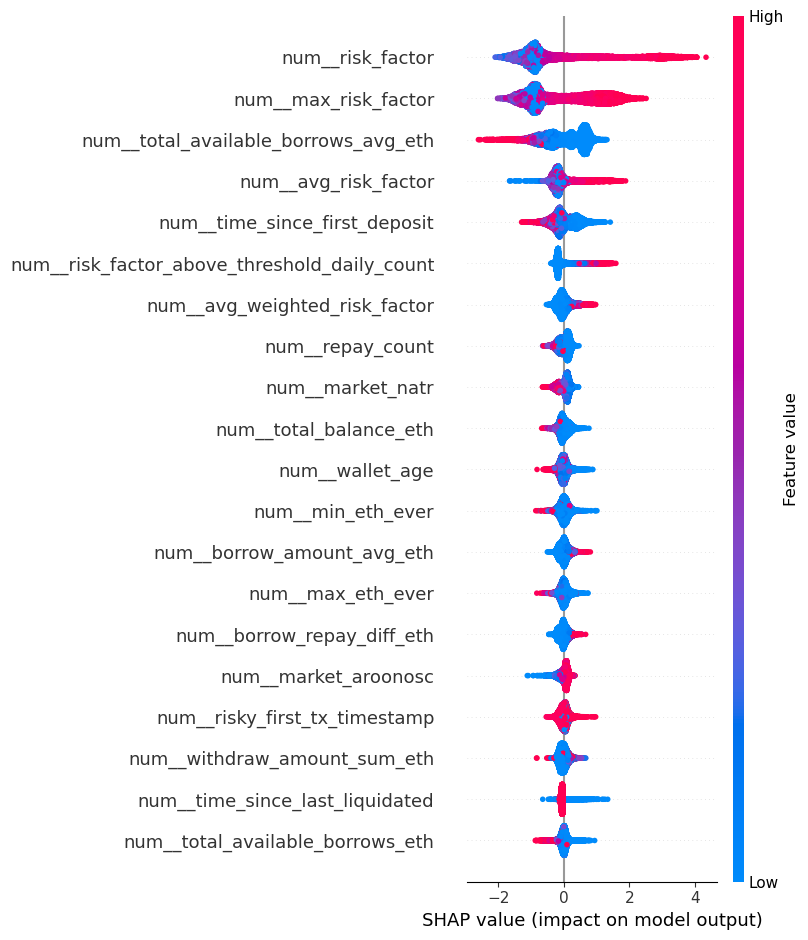

Interpretación para una observación específica (ejemplo: primera fila):


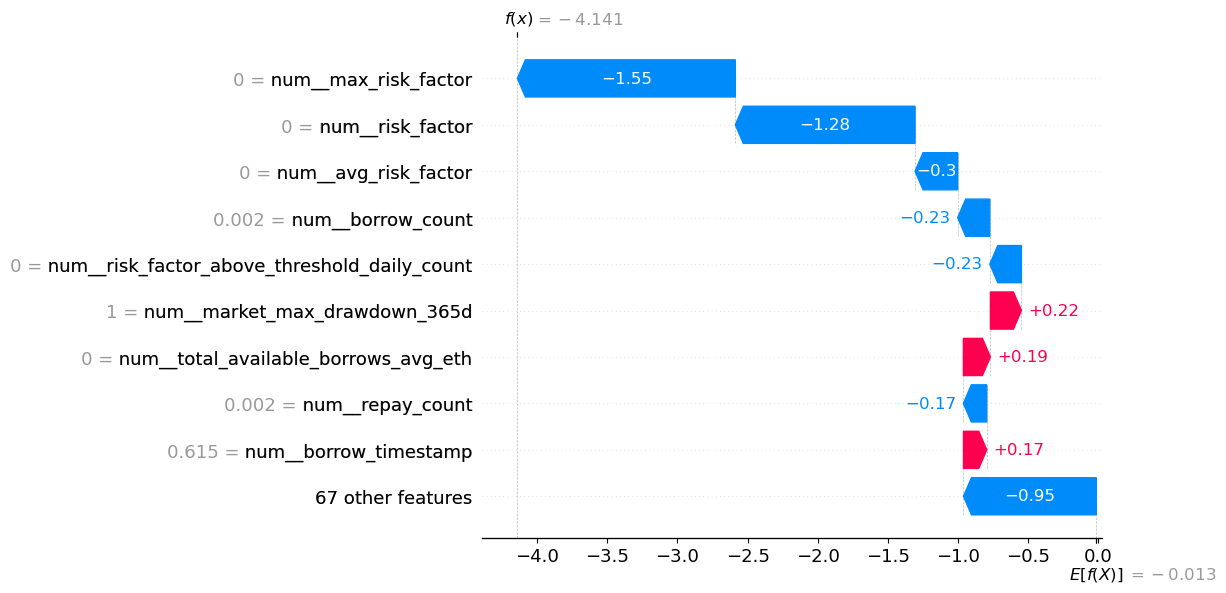

In [52]:
# Preprocesar los datos antes de aplicar SHAP
df_x_combined_processed = pipeline_xgb_completo.named_steps['preprocessing'].transform(df_x_combined)

# Extraer el modelo XGBoost entrenado del pipeline
xgb_model = pipeline_xgb_completo.named_steps['xgb_optimizado']

# Aplicar SHAP al modelo entrenado
explainer = shap.Explainer(xgb_model, df_x_combined_processed)

# Seleccionar una muestra representativa (para agilizar el tiempo de computo)
sample_fraction = 0.05
df_sample = df_x_combined_processed.sample(frac=sample_fraction, random_state=rd)

# Calcular SHAP values solo para la muestra
shap_values = explainer(df_sample)

# Generar gráficos para la muestra
shap.summary_plot(shap_values, df_sample)

print("Interpretación para una observación específica (ejemplo: primera fila):")
shap.waterfall_plot(shap_values[0])

El primer gráfico muestra un resumen global de los valores SHAP, destacando las variables más influyentes en el modelo. Variables como `num__risk_factor` y `num__max_risk_factor` tienen el mayor impacto, indicando que los factores de riesgo financiero son críticos para las predicciones. Los puntos rojos, que representan valores altos, tienden a aumentar las predicciones, mientras que los valores bajos (puntos azules) disminuyen la probabilidad del resultado positivo. Este análisis global subraya la importancia del riesgo financiero en el modelo.

El segundo gráfico, un waterfall plot, explica el impacto de las variables para una predicción específica. Aquí, `num__max_risk_factor` y `num__risk_factor` contribuyen significativamente a reducir el valor predicho, mientras que otras variables, como `num__market_max_drawdown_365d`, tienen aportes positivos menores. Este gráfico proporciona una interpretación clara de cómo cada característica afecta el resultado final de manera acumulativa.

Ambos gráficos destacan la relevancia de los factores de riesgo en el modelo.


A continuación se realizan tres predicciones.


Justificación para la predicción de la instancia 0:


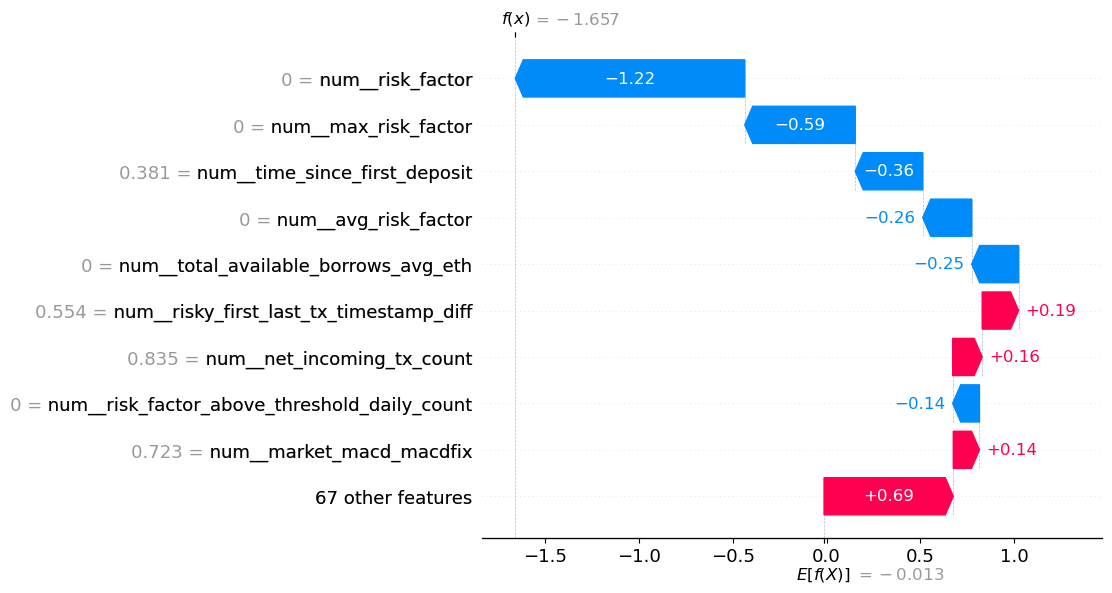


Justificación para la predicción de la instancia 10:


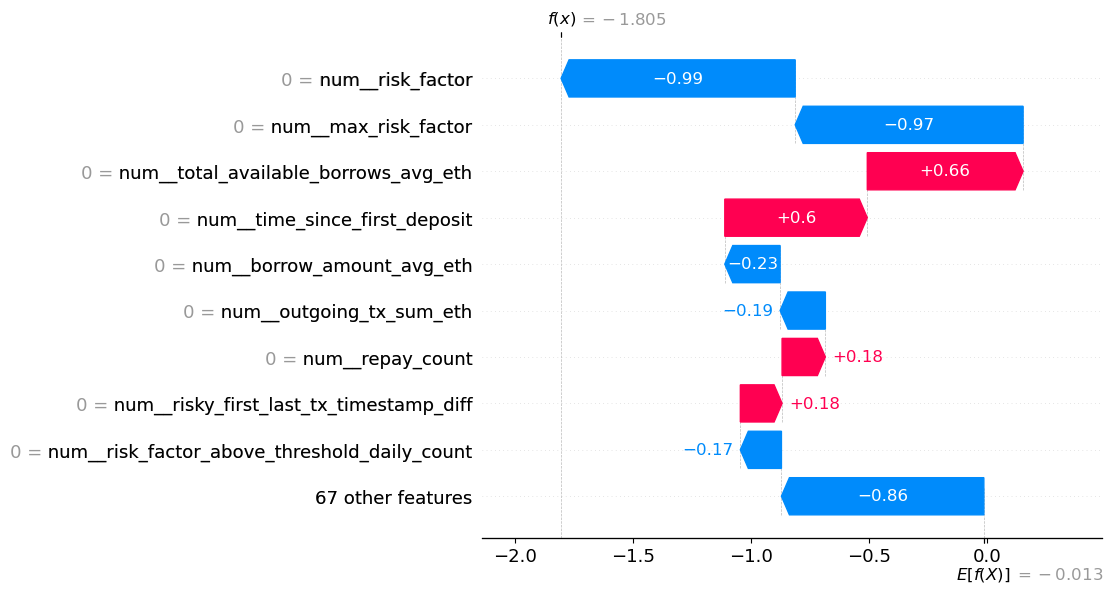


Justificación para la predicción de la instancia 50:


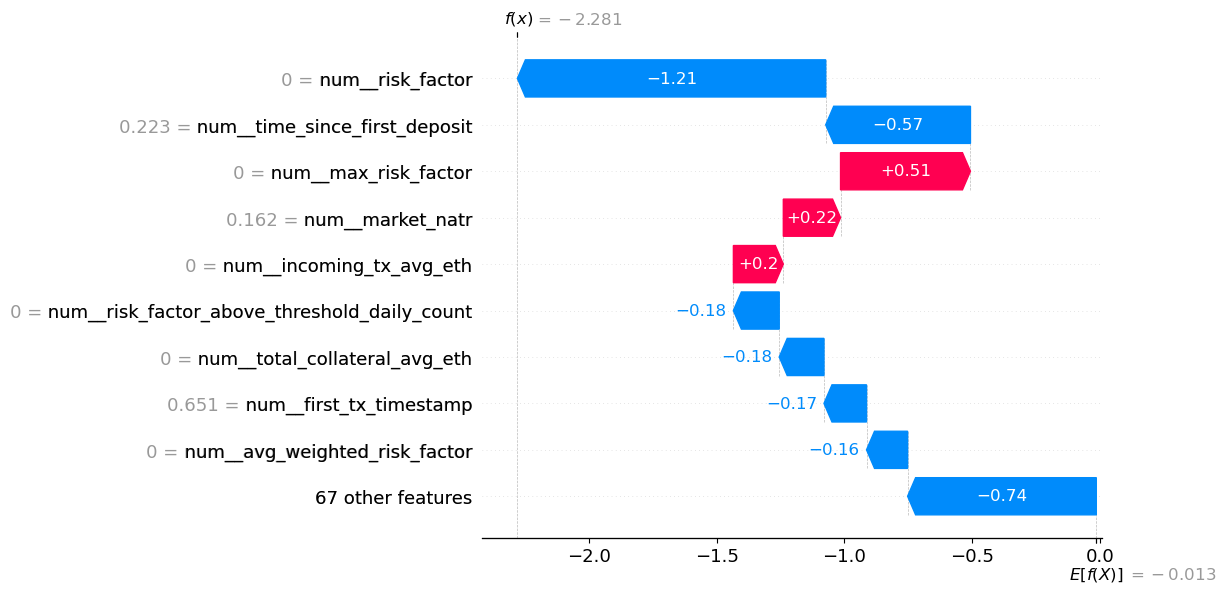

In [53]:
# Seleccionar tres instancias concretas del conjunto de prueba
indices_predicciones = [0, 10, 50] 
instancias_seleccionadas = X_test.iloc[indices_predicciones]

# Transformar las instancias seleccionadas usando el preprocesamiento del pipeline
instancias_transformadas = pipeline_xgb_completo.named_steps['preprocessing'].transform(instancias_seleccionadas)

# Calcular los SHAP values para las instancias seleccionadas
shap_values_seleccionados = explainer(instancias_transformadas)

# Generar justificaciones para cada predicción seleccionada
for i, idx in enumerate(indices_predicciones):
    print(f"\nJustificación para la predicción de la instancia {idx}:")
    shap.waterfall_plot(shap_values_seleccionados[i])

1. **Primera Predicción:**
   La variable `num__risk_factor` tiene el mayor impacto negativo, contribuyendo significativamente a disminuir la predicción del modelo. Por otro lado, la variable `num__market_macd_macdfix` influye positivamente, aunque en menor magnitud.

2. **Segunda Predicción:**
   En este caso, `num__risk_factor` y `num__max_risk_factor` reducen fuertemente la predicción. Sin embargo, variables como `num__time_since_first_deposit` aportan de manera positiva, compensando parcialmente el efecto negativo.

3. **Tercera Predicción:**
   La variable `num__risk_factor` nuevamente domina con un impacto negativo significativo. Factores como `num__market_natr` y `num__incoming_tx_avg_eth` contribuyen positivamente, pero no lo suficiente para contrarrestar la disminución general.




Se realiza otro gráfico donde se muestran las importancias de las características, todo esto con valor absoluto, siendo indiferente si afecta positiva o negativamente.

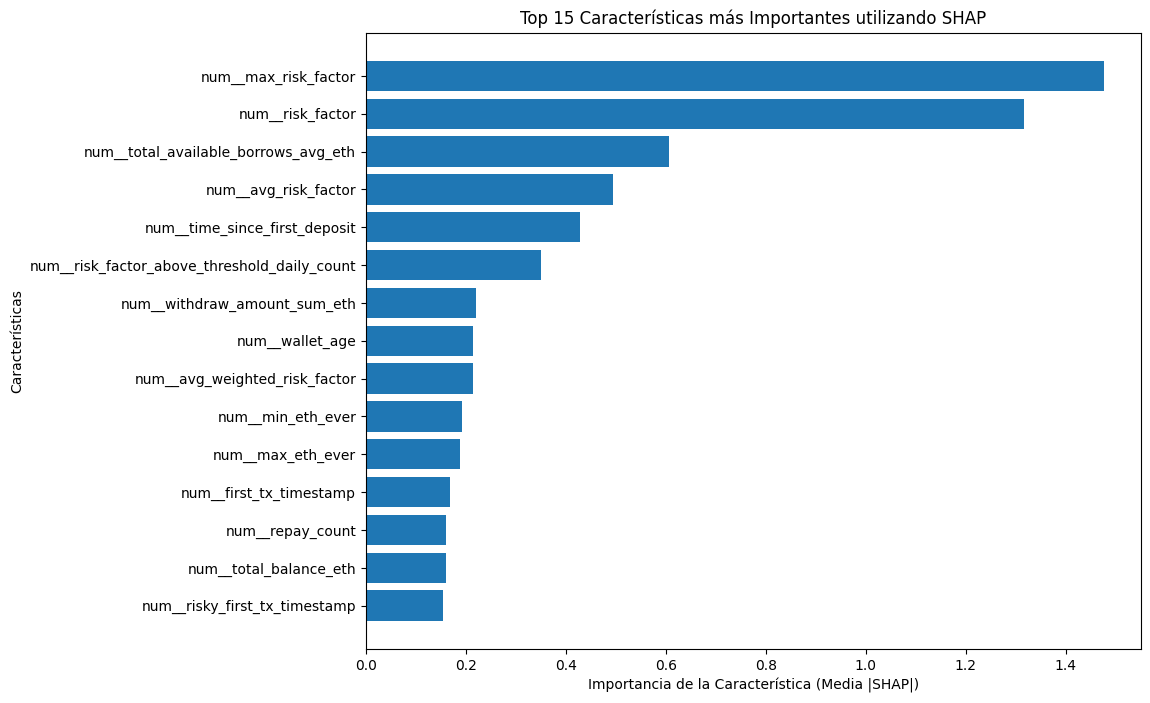

In [ ]:
# Calcular la importancia de las características utilizando los SHAP values
shap_values_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Crear un DataFrame con las características y su importancia
importance_df = pd.DataFrame({
    'feature': df_x_combined_processed.columns,
    'mean_importance': shap_values_abs_mean
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='mean_importance', ascending=True)

# Seleccionar las 10 características más importantes
top_10_features = importance_df.nlargest(15, 'mean_importance')

# Gráfico de barras horizontales para las 10 características más relevantes
plt.figure(figsize=(10, 8))
plt.barh(top_10_features['feature'], top_10_features['mean_importance'], capsize=5)
plt.xlabel("Importancia de la Característica (Media |SHAP|)")
plt.ylabel("Características")
plt.title("Top 15 Características más Importantes utilizando SHAP")
plt.gca().invert_yaxis()  
plt.show()


El gráfico muestra las 15 características más importantes del modelo según los valores SHAP. Las dos variables más influyentes son `num__max_risk_factor` y `num__risk_factor`, destacándose con una contribución significativamente mayor en comparación con las demás. Esto indica que los factores de riesgo tienen un impacto determinante en las predicciones del modelo. Otras variables como `num__total_available_borrows_avg_eth` y `num__avg_risk_factor` también son relevantes, aunque con una influencia menor. La importancia decreciente hacia las últimas posiciones sugiere que estas características aportan información complementaria pero menos decisiva para las predicciones.


A modo de conclusión, el modelo tiene un fuerte sesgo hacia las variables asociadas al riesgo.

Este comportamiento es esperable dadas las características del problema que se está tratando. A pesar de poder ver un sesgo en el modelo, se decidió no intervenir en él, ya que se considera una relación natural de las variables.

---

## **MLOPS**

### **Tracking con MLFlow**

Durante el proceso de modelamiento del proyecto, se cumplió con el seguimiento detallado de los elementos generados, utilizando MLflow como herramienta principal. Se rastrearon experimentos, entrenamientos y versiones de los modelos, registrando métricas de desempeño como AUC-PR, precisión, recall y F1-score, así como los hiperparámetros clave utilizados en cada ejecución. Además, se documentaron y optimizaron los modelos a través de herramientas como Optuna, asegurando interpretabilidad y trazabilidad en todas las etapas del pipeline. 

#### **Experimentos**

A lo largo del desarrollo del proyecto, se realizaron tres experimentos principales, correspondientes a las tres etapas del proyecto:

##### **1. Etapa 1: Exploración y Selección de Modelos**
- **Nombre del Experimento**: `Etapa 1 Proyecto`
- **Runs Principales**:
  1. `XGBoost - Primera Iteración`
  2. `LightGBM - Primera Iteración`
  3. `CatBoost - Primera Iteración`
  4. `Regresión Logística - Primera Iteración`
- **Propósito**:
  - Comparar diferentes algoritmos de aprendizaje supervisado para identificar el más prometedor en términos de desempeño inicial.
  - Métrica utilizada: AUC-PR, F1-Score, Precision y Recall.
- **Duración**:
  - Varió según el modelo. Por ejemplo, el entrenamiento de XGBoost duró **17.7 minutos**, el cual fue el modelo con mejor desempeño.


##### **2. Etapa 2: Reentrenamiento**
- **Nombre del Experimento**: `Etapa 2 Proyecto`
- **Runs Principales**:
  1. `XGBoost - Reentrenamiento con Datos Adicionales` (dos ejecuciones, con y sin subsampling).
- **Propósito**:
  - Evaluar el impacto del uso de datos adicionales en el desempeño del modelo base.
  - Ajustar el modelo entrenado previamente para incorporar más información.
- **Resultados**:
  - El modelo sin balanceo de clases fue el más efectivo.


##### **3. Etapa 3: Optimización y Pipeline Final**
- **Nombre del Experimento**: `Etapa 3 Proyecto`
- **Runs Principales**:
  1. `Optuna Optimization`
  2. `XGBoost Pipeline - Entrenamiento Completo`
  3. `XGBoost - Reentrenamiento con Todos los Datos` (dos ejecuciones).
- **Propósito**:
  - Realizar una optimización de hiperparámetros utilizando Optuna.
  - Integrar todo el pipeline, incluyendo preprocesamiento y el modelo final.
  - Crear un modelo robusto para la entrega final.
- **Resultados**:
  - El experimento `XGBoost Pipeline - Entrenamiento Completo` alcanzó un desempeño satisfactorio.
  - Métricas registradas: AUC-PR, precisión, recall, y F1-score.


#### Elementos Rastreados

En cada etapa se rastrearon los siguientes elementos mediante MLflow:
- **Hiperparámetros**:
  - Principalmente `learning_rate`, `max_depth`, `n_estimators`, `reg_alpha`, `reg_lambda`, `subsample`, de XGboost, el modelo principalmente utilizado.
- **Métricas**:
  - **AUC-PR**: Métrica personalizada implementada para todas las etapas.
  - **Precisión**, **Recall**, y **F1-score**: Especialmente relevantes para la evaluación de modelos en etapas avanzadas.

#### Conclusiones

1. **Etapa 1** permitió seleccionar XGBoost como el modelo más prometedor basado en métricas de desempeño inicial.
2. **Etapa 2** se utilizó reentrenamiento con datos adicionales para mejorar el modelo de la etapa anterior.
3. **Etapa 3** culminó con un pipeline final robusto, probando optimizaciones con Optuna y validado con múltiples métricas, lo que permitió obtener un modelo satisfactorio para la entrega final.

### Desarrollo de Aplicación Web

Para facilitar la consulta del modelo final por parte de un cliente, se desarrolló una aplicación web que cumple con los requisitos especificados:

#### Frontend con Gradio
Se creó una interfaz amigable utilizando Gradio que permite al usuario interactuar de forma intuitiva con el modelo.
La interfaz proporciona dos opciones para ingresar los datos:
Carga de un archivo .csv: El usuario puede cargar un archivo con múltiples registros para predicción masiva.
Formulario manual: El usuario puede ingresar los valores de las características de forma manual para predicción individual.

#### Backend con FastAPI
El backend fue desarrollado con FastAPI, implementando la lógica de inferencia del modelo de manera eficiente.
El backend recibe las solicitudes desde el frontend, procesa los datos y retorna las predicciones del modelo.

#### Dockerización
Tanto el frontend como el backend fueron dockerizados utilizando Docker para garantizar portabilidad y facilidad de despliegue en cualquier entorno.
Se crearon dos archivos Dockerfile, uno para el backend y otro para el frontend, y un archivo docker-compose.yml para gestionar ambos servicios de manera integrada.

#### Comunicación Backend-Frontend
Se estableció una comunicación fluida entre el backend y el frontend mediante una configuración en docker-compose.
La implementación asegura que el flujo entre la carga de datos, la inferencia y la visualización de resultados sea eficiente y transparente para el usuario.

#### Resultado
Esta solución web permite al cliente interactuar con el modelo de manera simple y flexible, cumpliendo con los requisitos planteados para facilitar tanto predicciones individuales como masivas. Los archivos necesarios para la aplicación están adjuntos a esta entrega.

### Monitoreo

Debido a la limitación de tiempo disponible, no se logró implementar un sistema completo de monitoreo para garantizar la consistencia de los datos y el desempeño del modelo en producción. Esto incluye aspectos críticos como:

- **Data Drift:** Desarrollo de un método para detectar diferencias significativas entre los nuevos datos y los datos originales.
- **Evaluación Continua:** Supervisión constante del rendimiento del modelo en producción para identificar desviaciones y anomalías.

**Próximos Pasos:**
1. Implementar un sistema de monitoreo para detectar data drift utilizando herramientas de divergencia estadística.
2. Diseñar estrategias para abordar desequilibrios en los datos, como el reentrenamiento del modelo con técnicas de balanceo.
3. Configurar alertas automatizadas que permitan identificar cambios significativos en los datos o en las métricas de desempeño del modelo en tiempo real.

### Canalización Productiva

La canalización productiva solicitada no pudo ser implementada durante este proyecto debido a restricciones de tiempo. Esto incluye tareas clave como:

1. Extracción de datos: Integración con fuentes como GitLab para obtener datos automáticamente.
2.Limpieza y transformación: Automatización del procesamiento de datos para garantizar su calidad.
3. Análisis de Data Drift: Comparación entre los datos nuevos y el conjunto original.
4. Reentrenamiento del modelo: Automatización del reentrenamiento cuando se detecte data drift.
5. Tracking de interpretabilidad: Registro de interpretaciones generadas por herramientas como SHAP.

**Próximos Pasos:**
1. Diseñar e implementar un pipeline con Apache Airflow para orquestar las tareas de extracción, limpieza, análisis de data drift, y reentrenamiento.
2. Incorporar Optuna para optimizar automáticamente los hiperparámetros del modelo en cada ciclo de reentrenamiento.
3. Registrar y supervisar métricas de desempeño e interpretabilidad con MLflow y herramientas como SHAP.
4. Asegurar la idempotencia del pipeline y realizar pruebas para garantizar su robustez en escenarios de producción.
5. Crear una representación visual del pipeline y documentar los beneficios de la automatización para la toma de decisiones.

La implementación de estas funcionalidades es esencial para garantizar que el modelo sea capaz de adaptarse a cambios en los datos y continuar entregando predicciones precisas y consistentes en producción.

---
## **Resultados**

#### **Desempeño de los modelos y evolución a lo largo de las iteraciones**
1. **Primera Iteración (Etapa 1):**
   - Inicialmente se utilizó como baseline el modelo **Regresión Logística** y a continuación se utilizaron tres modelos basados en árboles, **CatBoost**, **LightGBM** y **XGBoost**.
   - Una vez probados todos los modelos, se llegó a la conclusión de que **XGBoost** fue el mejor, dando las siguientes métricas:
      - AUC-PR: 0.973
      - F1-Score: 0.910
      - Precision: 0.938
      - Recall: 0.883
   - En esta primera etapa no existía un desbalanceo de clases notorio, lo que facilitó el entrenamiento. Si bien se obtuvieron resultados muy favorables, el modelo no tenía una capacidad de generalización alta, ya que en la competencia se obtuvo un **AUC-PR de 0.79**. Sin embargo, de aquí en adelante el proyecto se centrará en XGBoost por sus resultados prometedores.

2. **Segunda Iteración (Etapa 2):**
   - Se utilizó como base exacatamente el mismo modelo de la etapa anterior, pero se reentrenó utilizando los nuevos datos. 
   - Debido al desbalance de clases de los nuevos datos entregados para esta etapa, se probó utilizar subsampling para balancerlas, aunque no se tuvieron mejores resultados que el modelo sin balance.
   - Las métricas que se obtuvieron fueron:
      - AUC-PR: 0.97
      - F1-Score: 0.87
      - Precision: 0.92
      - Recall: 0.82
   - Esta vez el modelo sí tuvo un mejor desempeño en la competición con un **AUC-PR de 0.85**, por lo que logró generalizar de mejor manera.

3. **Tercera Iteración (Etapa 3):**
   - Se utilizó la misma metodología de la etapa 2 con los nuevos datos, aunque nuevamente balancear las clases no fue útil y el rendimiento del modelo era bastante bajo.
   - Debido a la situación anterior, se tomó la decisión de utilizar todos los datos dados durante el proyecto. En primera instancia se usaron los hiperparámetros de la etapa 1, lo que resultó en los mejores resultados y el modelo final subido a CodaLab.
   - Si bien se utilizó Optuna para la búsqueda de mejores hiperparámetros, no fue posible, ya que daban peores resultados, pero sirvió para identificar los parámewtros más relevantes en **XGBoost**
   - Las métricas del modelo final fueron las siguientes:
      - AUC-PR: 0.94
      - F1-Score: 0.85
      - Precision: 0.91
      - Recall: 0.80
   - Para la competencia en CodaLab se obtuvo un **AUC-PR de 0.75**, lo cual, si bien estuvo bien posicionado en el ránking, se esperaba un mejor desempeño del modelo.



#### **Significado de los resultados en términos prácticos**
Los resultados obtenidos a lo largo de las tres iteraciones muestran un modelo con un buen desempeño para identificar patrones complejos en los datos, lo que podría ser aprovechado en el problema real para realizar predicciones de alta precisión sobre casos futuros. Las métricas como el **AUC-PR** de 0.94 y el **F1-Score** de 0.85 en la etapa final indican que el modelo puede manejar tanto la precisión como el recall de manera equilibrada, siendo útil en escenarios donde ambas métricas son críticas. En particular, la capacidad del modelo para destacar características clave a través de SHAP refuerza su interpretabilidad, permitiendo a los expertos comprender qué factores contribuyen más a las predicciones, lo cual es crucial en aplicaciones reales que requieren confianza en la toma de decisiones.

Si bien las métricas internas del modelo son sólidas, el desempeño en la competencia de CodaLab, con un **AUC-PR de 0.75** en la etapa final, refleja una disminución en la capacidad de generalización del modelo al enfrentarse a datos no vistos. Esto indica que, aunque el modelo tiene un buen desempeño general, aunque podría ser susceptible a problemas de overfitting o desbalance en los datos de entrenamiento. 



#### **Hiperparámetros Relevantes**
Como se analizó en el desarrollo de la etapa 3, los hiperparámetros más relevantes de **XGBoost** son *max_depth* y *n_estimators*, ambos son fundamentales para el desempeño del modelo, ya que el primero define la profundidad máxima de los árboles de decisión, lo que permite al modelo capturar patrones complejos en los datos y el segundo indica el número de árboles de decisión a entrenar, donde un mayor número de árboles incrementa la capacidad del modelo para reducir el error, pero también puede generar overfitting si no se regula adecuadamente.

#### **Factores Relevantes** 
Por lo aprendido en asignaturas del MDS, se consideraron como hiperparámetros relevantes en el modelo **XGBoost** los reguladores *alpha* y *lambda*, los cuales ayudan a la generalización de los modelos para evitar overfitting, además de los hiperparámetros mencionados anteriormente.

Durante el desarrollo de los entrenamientos se cayó bastantes veces en underfitting por la capacidad computacional, al no poder usar todos los datos simultáneamente o utilizar más iteraciones en Optuna.

---
## **Conclusiones**

#### **Identificación de los modelos con mejor desempeño**
Durante el proyecto, se realizaron experimentos exhaustivos para identificar los modelos con mayor capacidad de abordar el problema planteado. Tras una serie de iteraciones:
- **Etapa 1** permitió seleccionar **XGBoost** como el modelo más prometedor debido a su desempeño superior en métricas como AUC-PR y F1-score en comparación con otros algoritmos como LightGBM y CatBoost.
- En **Etapa 2**, el reentrenamiento con datos adicionales proporcionó una mejora en los resultados, destacándose la versión sin balanceo de clases por su mejor desempeño en el conjunto de prueba.
- Finalmente, en **Etapa 3**, el modelo **XGBoost** con los hiperparámetros de la etapa 1 alcanzó métricas satisfactorias para la entrega final.

#### **Observaciones generales sobre los datos y la problemática**
- El desequilibrio de clases representó un desafío significativo, especialmente en las dos últimas iteraciones. Para esto se emplearon técnicas como el uso de subsampling para mejorar la representatividad de las clases minoritarias, aunque sin éxito.
- Los datos adicionales proporcionados en las etapas avanzadas permitieron capturar más patrones y mejorar el rendimiento del modelo en general.
- El uso de AUC-PR fue crucial para evaluar adecuadamente el desempeño de los modelos en un contexto con clases desbalanceadas.
- **Limitaciones detectadas** debido a la limitación de tiempo y computo: 
  - No se intentó crear nuevas categorías a partir de las variables existentes.
  - No se redujo la dimensionalidad ni se eliminaron posibles outliers en los datos.
  - El uso de más modelos y recursos podría haber permitido una optimización más exhaustiva con Optuna, mejorando potencialmente los resultados finales.

#### **Reflexiones sobre las herramientas y técnicas utilizadas**
- **MLflow** fue una herramienta clave para el seguimiento de experimentos, permitiendo rastrear métricas, hiperparámetros y versiones de los modelos, lo que facilitó la comparación entre diferentes enfoques.
- **Optuna** fue importante para la optimización de hiperparámetros en la etapa final, identificando configuraciones que mejoraron significativamente el desempeño del modelo y los hiperparámetros más relevantes. Con la limitación de que con más capacidad de computo se podría haber llegado a un resultado mejor.
- El enfoque de integración los pipelines combinando preprocesamiento y modelado, resultó en un flujo reproducible y escalable para futuras implementaciones.
- Aunque en general las herramientas utilizadas fueron eficaces, el proceso de optimización y entrenamiento presentó limitaciones en términos de tiempo de cómputo, lo que podría mejorarse con recursos más avanzados.
- Si bien los resultados obtenidos en la competencia fueron buenos, el desempeño podría haberse mejorado con exploraciones adicionales y un enfoque más amplio de optimización.

#### **Visión global del proyecto**
En resumen, este proyecto implementó un flujo iterativo efectivo para abordar una problemática compleja, avanzando desde la exploración inicial de modelos hasta la construcción de una solución optimizada y robusta. Decisiones clave, como la selección de XGBoost, resultaron fundamentales para alcanzar un modelo final que cumple con los objetivos planteados. Sin embargo, la falta de una exploración más profunda de aspectos como los cambios en las distribuciones de los datos adicionales limitó el potencial del modelo. Esto deja margen para mejoras futuras que podrían elevar aún más su desempeño y efectividad.